In [ ]:
import shutil
!rm -rf /content/data
shutil.copytree('/content/drive/MyDrive/ML_course_NSU/NSU/competition/data', '/content/data')
!mkdir /root/.kaggle
!cp /content/data/kaggle.json ~/.kaggle/kaggle.json

!pip install catboost
!pip install shap

# Load

In [1]:
# catboost 
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')


train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
test_df['Sales'] = -1



print(train_df.shape, test_df.shape)
df = pd.concat([train_df, test_df]).reset_index()

# drop bad records
df = df[~pd.to_numeric(df['Days in stock'], errors='coerce').isna()]
df.loc[:, 'Days in stock'] = df['Days in stock'].astype(float)
df.Rating = df.Rating.str.replace(',', '.').astype(float)

df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(751774, 13) (83531, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,index,Average price,Brand,Category,Comments,Days in stock,Deliveryscheme,Id,Max price,Min price,Name,Price,Rating,Sales,Seller
0,0,489.000000,AirWick,Бытовая химия/Освежители и ароматизаторы/Арома...,0,18.0,FBS,NaN,549.0,329.0,Сменный аэрозоль AirWick Дикий Гранат 250мл,489.0,0.0,1.0,"ЕкомСистема, доставка OZON"
1,1,1631.000000,Pavone,Дом и сад/Декор и интерьер/Оформление интерьер...,0,4.0,FBO,NaN,1631.0,1631.0,"Фигурка декоративная Pavone Ангел JP-05/ 6, 1...",1631.0,0.0,1.0,Art East
2,2,400.000000,Золото Индии,"Продукты питания/Масла, соусы, специи/Специи и...",3,22.0,FBS,NaN,400.0,400.0,Фенугрек/Пажитник молотый (Fenugreek (Methi) P...,400.0,5.0,13.0,"ООО ""Амрита"", доставка OZON"
3,3,713.333333,Castorland,Хобби и творчество/Пазлы и головоломки/Пазлы/C...,0,8.0,FBS,NaN,740.0,660.0,Пазл Castorland 1000 деталей: Ожившая картина,660.0,0.0,3.0,"ShopUdachi.ru, доставка OZON"
4,4,2881.000000,Siku,Детские товары/Игрушки и игры/Игрушечный транс...,0,1.0,FBS,NaN,2881.0,2881.0,"SIKU Самосвал Liebherr T 264, 1:87",2881.0,0.0,1.0,"Gnom.land, доставка OZON"


# EDA

FIX TYPES

In [9]:
df['Rating'].value_counts()

0,0000    569432
5,0000    106229
4,0000     15022
4,5000      9998
3,0000      7659
           ...  
1,6400         1
1,6100         1
2,0400         1
1,8500         1
2,9800         1
Name: Rating, Length: 314, dtype: int64

In [2]:
# убираем невалидные значения и преобразовываем рейтинг
# Pipeline
df = df[~pd.to_numeric(df['Days in stock'], errors='coerce').isna()]
df.loc[:, 'Days in stock'] = df['Days in stock'].astype(float)
df.Rating = df.Rating.str.replace(',', '.').astype(float)

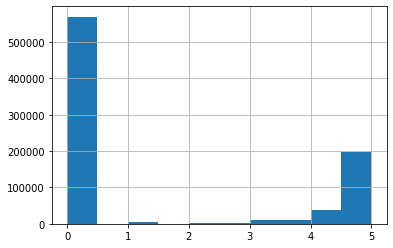

In [21]:
df.Rating.hist()

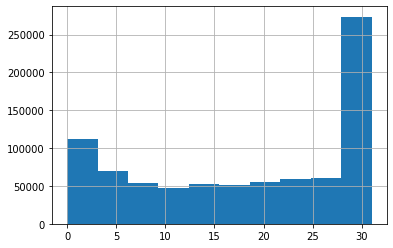

In [22]:
df['Days in stock'].hist()

**PREPARE QUANTATIVE**

In [68]:
df[df['Sales'] == -1].shape

(83531, 15)

In [161]:
# Выбрасываем оутлаеры (ковры за 2 ляма)
# pipeline
df.drop(df[df.Name.str.contains('I-Carpets') & (df['Max price'] > 100000) & (df['Sales'] != -1)].index, inplace=True)

df.drop(df[(df['Max price'] > 4000000) & (df['Sales'] != -1)].index, inplace=True)

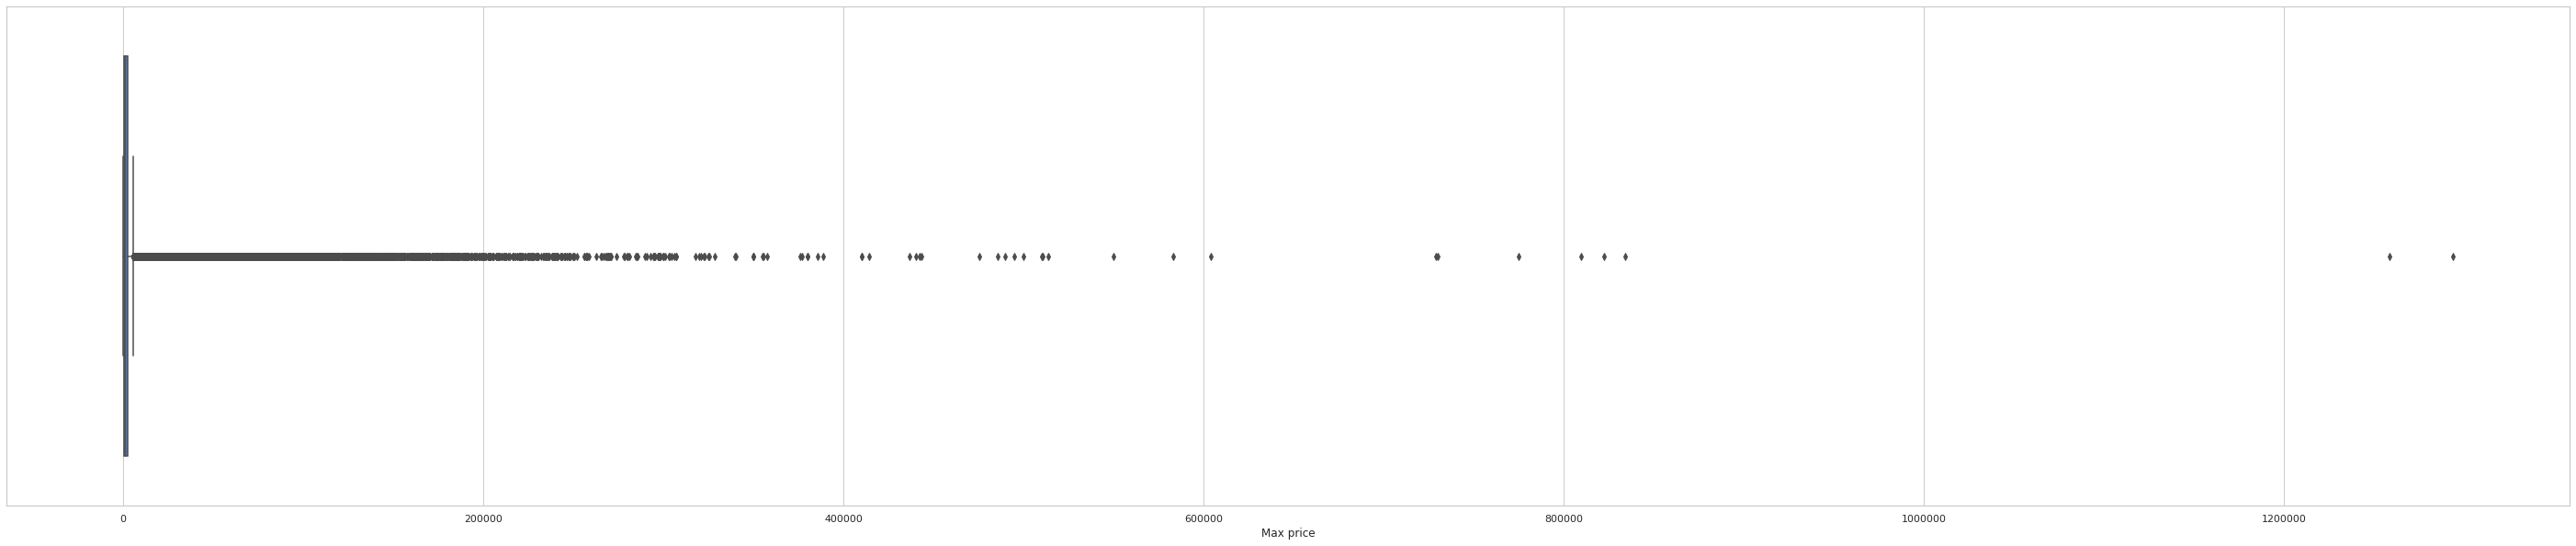

In [80]:
import seaborn as sns
plt.figure(figsize=(50, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df[(df['Sales'] != -1)]["Max price"])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

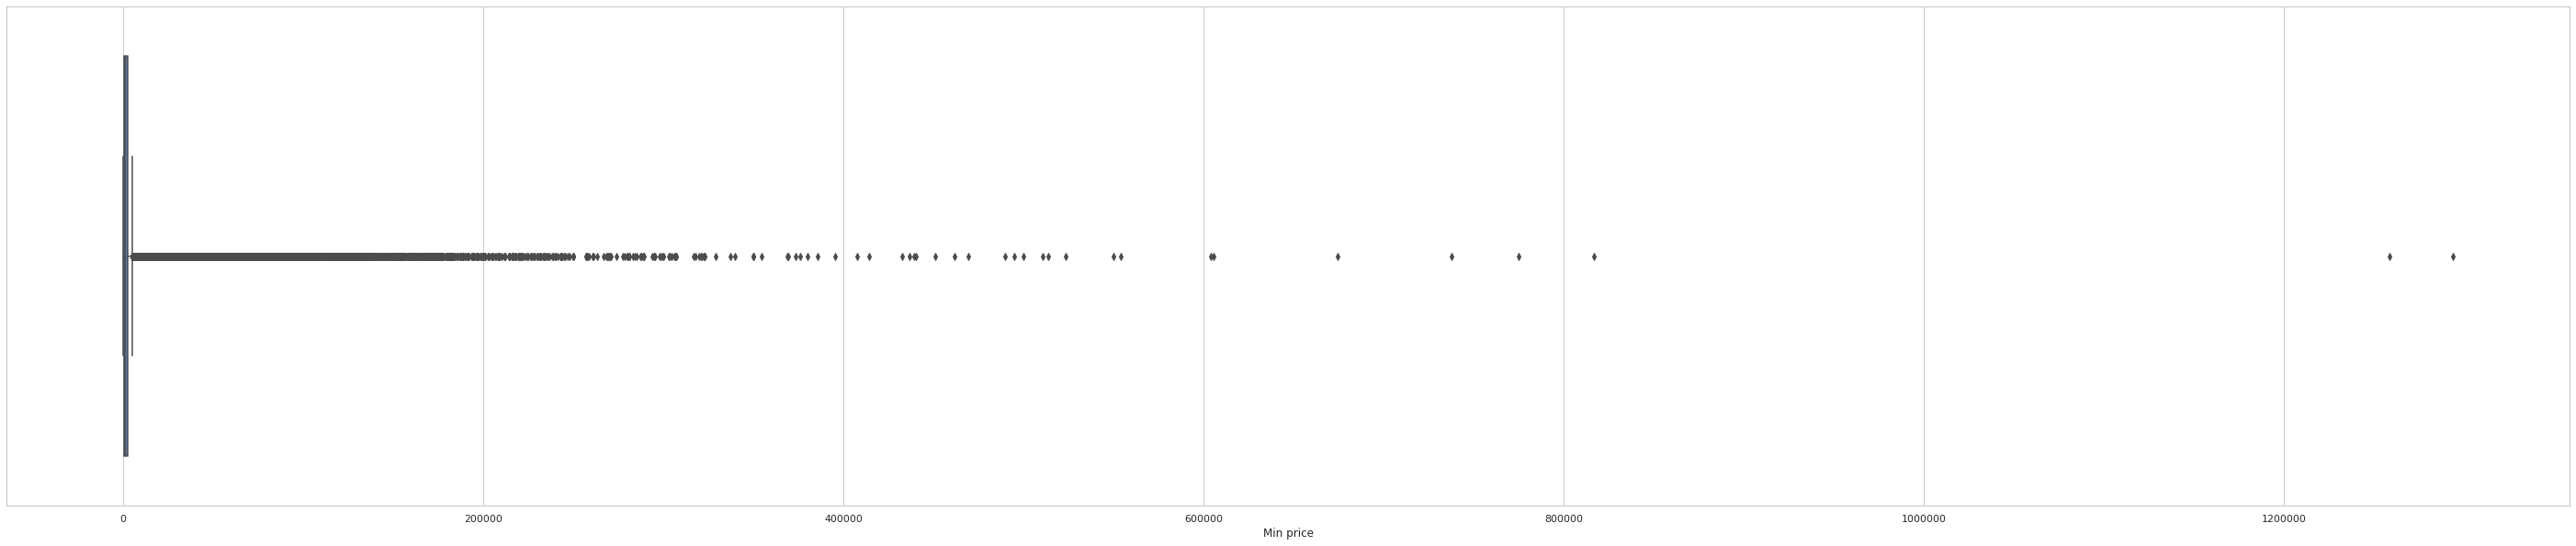

In [82]:
import seaborn as sns
plt.figure(figsize=(50, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df[(df['Sales'] != -1)]["Min price"])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

In [162]:
# изменение цены за T
# pipeline
df['Delta price'] = df['Max price'] - df['Min price']
df['RatioPrice'] = df['Min price'] / df['Max price']

In [88]:
df['Delta price'].min()

0.0

In [90]:
df['RatioPrice'].isna().sum()

0

In [ ]:
import seaborn as sns
plt.figure(figsize=(50, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['Delta price'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

In [159]:
df['Average price'].isna().sum()

75936

In [167]:
# pipeline

df['Average price'].fillna((df['Max price']+df['Min price']) / 2, inplace=True)
df.drop(columns=['Max price', 'Min price', 'Price'], inplace=True)

In [168]:
df.corr().style.background_gradient(cmap='coolwarm')

,index,Comments,Rating,Average price,Days in stock,Sales,Id,Delta price,RatioPrice
index,1.000000,0.000337,0.001478,-0.001897,-0.000167,0.031915,1.000000,0.001782,-0.000457
Comments,0.000337,1.000000,0.125352,-0.004408,0.047846,0.035718,0.001389,-0.001466,-0.051064
Rating,0.001478,0.125352,1.000000,-0.028478,0.133823,0.001650,-0.005672,-0.024576,-0.097409
Average price,-0.001897,-0.004408,-0.028478,1.000000,-0.008446,-0.007910,-0.003519,0.116935,0.008503
Days in stock,-0.000167,0.047846,0.133823,-0.008446,1.000000,-0.034468,0.004986,0.041468,-0.193436
Sales,0.031915,0.035718,0.001650,-0.007910,-0.034468,1.000000,nan,-0.013676,0.022151
Id,1.000000,0.001389,-0.005672,-0.003519,0.004986,nan,1.000000,0.004231,-0.002014
Delta price,0.001782,-0.001466,-0.024576,0.116935,0.041468,-0.013676,0.004231,1.000000,-0.294286
RatioPrice,-0.000457,-0.051064,-0.097409,0.008503,-0.193436,0.022151,-0.002014,-0.294286,1.000000


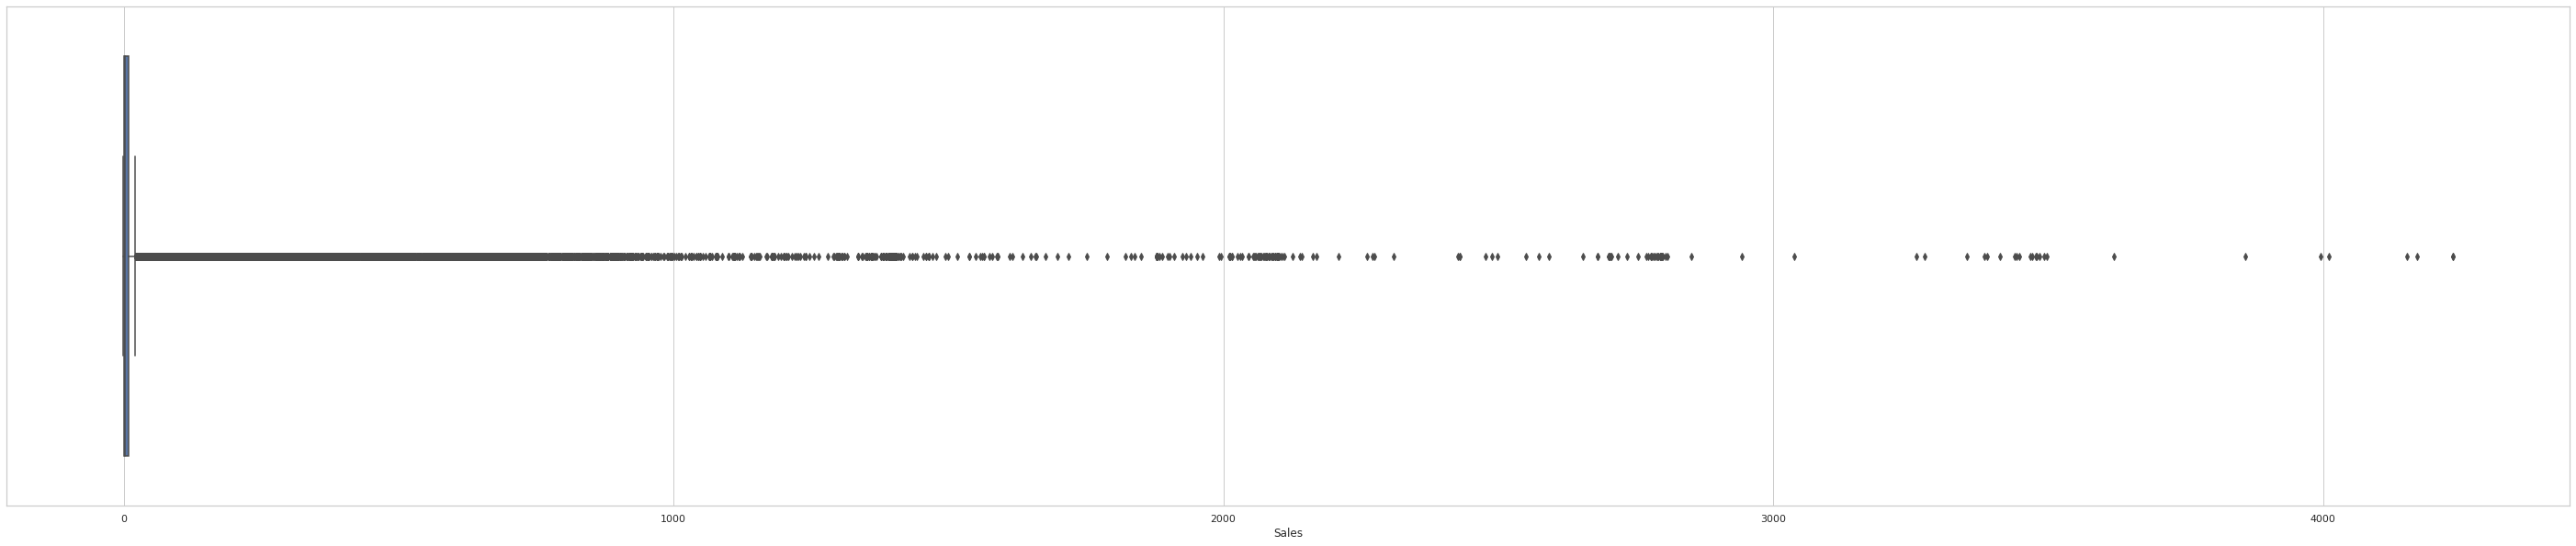

In [170]:
import seaborn as sns
plt.figure(figsize=(50, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['Sales'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

**PREPARE QUANTATIVE(COMMENTS)**

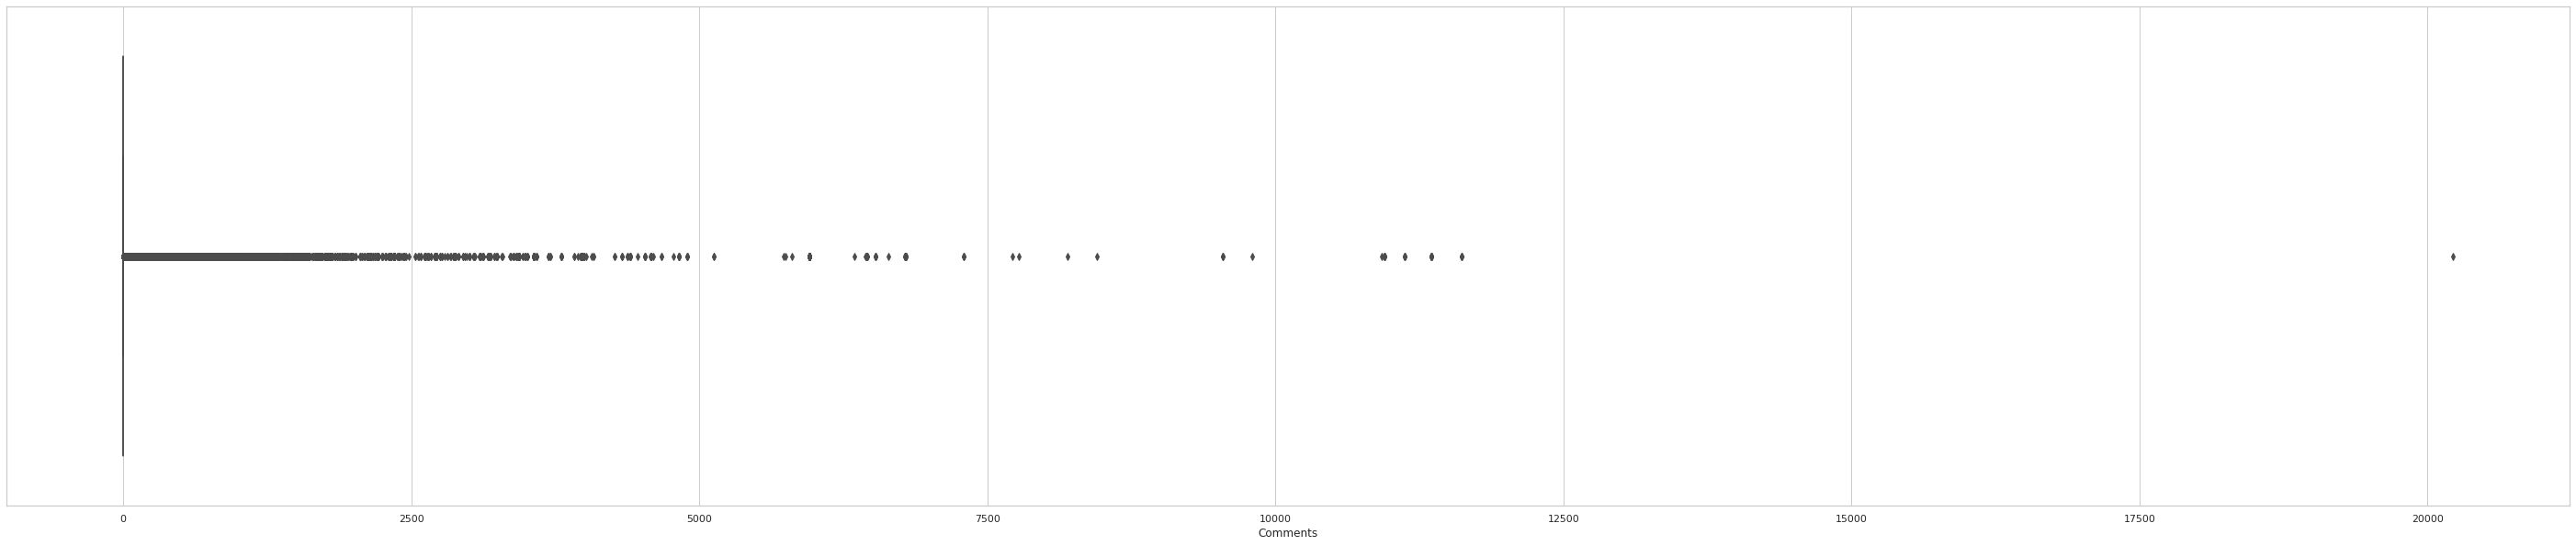

In [157]:
import seaborn as sns
plt.figure(figsize=(50, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['Comments'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

In [156]:
# pipeline
# выкидываем оутлаеры в comments
df.drop(df[(df['Comments'] > 12500) & (df['Sales'] != -1)].index, inplace=True)

**PREPARE CATEGORICAL (BRAND)**

In [16]:
df['Brand'].value_counts()

Без бренда      5334
Xiaomi          4095
Декатлон        3456
Bondibon        2814
ТВОЕ            2750
                ... 
ATTIC21            1
Nitras             1
Tribogreen         1
Stimlex            1
Источник Био       1
Name: Brand, Length: 41847, dtype: int64

In [94]:
df['Brand'].isna().sum()

57637

In [105]:
def get_fake_brand(x):
    return x.split('/')[-1]
    
df.loc[df['Brand'].isna(), 'Brand'] = df['Category'].apply(get_fake_brand)[df['Brand'].isna()]

In [106]:
df['Brand'].value_counts()

Без бренда                5336
Xiaomi                    4121
Декатлон                  3459
Bondibon                  2814
ТВОЕ                      2750
                          ... 
LANKOMA                      1
Энергопром Home Master       1
OFKA                         1
Flowers with Love            1
ЭДЕЛЬ                        1
Name: Brand, Length: 44983, dtype: int64

In [110]:
df['Brand'] = df['Brand'].str.replace(' ', '', regex=True)
df['Brand'] = df['Brand'].str.lower()

In [22]:
def set_rare_values(df, col, perc=0.1):
    frequencies = df.Seller.value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > perc).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < threshold, 'Rare')
    return df

def get_fake_brand(x):
    return x.split('/')[-1]

# pipeline
# Заполняем None бренда по последней категории в Category 
df.loc[df['Brand'].isna(), 'Brand'] = df['Category'].apply(get_fake_brand)[df['Brand'].isna()]
# Rating по каждому бренду
df['BrandRating'] = df.groupby('Brand').Price.transform('count')

# Создаем рейтинг для каждого бренда, зануляем Rating для no name ""
df['BrandRating'] = df.groupby('Brand').Price.transform('count')
df.loc[df['Brand'].str.startswith('Без бренда'), 'BrandRating'] = 0
df.loc[df['Brand'].str.startswith('NoName'), 'BrandRating'] = 0

# делаем Rare категорию
set_rare_values(df, 'Brand', perc=0.4)

# ! Можем объеденить бренды с разными показателями
# df['Brand'] = df['Brand'].str.replace(' ', '', regex=True)
# df['Brand'] = df['Brand'].str.lower()

len(df['Brand'].value_counts())

1004

**PREPARE CATEGORICAL (SELLER)**

In [172]:
df['Seller'].value_counts()

OZON                             67799
ONLINEZAP, доставка OZON         22084
Interparts MSK, доставка OZON     8835
SELLECOM, доставка OZON           8042
Shopotam                          6622
                                 ...  
Вертекс                              1
Баймобайл                            1
ИП Мудров Евгений Геннадьевич        1
Ullo                                 1
Philips                              1
Name: Seller, Length: 23084, dtype: int64

In [6]:
df['Seller'].value_counts().sort_values()

ООО "Платочная мозаика"              1
Удивительная спальня                 1
Glass Flowers                        1
Касперис, доставка OZON              1
Linkmag                              1
                                 ...  
Shopotam                          6622
SELLECOM, доставка OZON           8042
Interparts MSK, доставка OZON     8835
ONLINEZAP, доставка OZON         22084
OZON                             67799
Name: Seller, Length: 23084, dtype: int64

In [8]:
cum_sum = (df['Seller'].value_counts().sort_values().cumsum() / 835302)
cum_sum[cum_sum < 0.50]

ЗОДИАК БЕСПРОВОДНЫЕ РЕШЕНИЯ                0.000001
ИП Коршикова Наталья Юрьевна               0.000002
Альтаир                                    0.000004
ИП Лаврова К.А.                            0.000005
RKwооf, доставка OZON                      0.000006
                                             ...   
ОНИКС ПРО, доставка OZON                   0.498524
Волшебная маска                            0.498821
Дерзкие скидки, доставка OZON              0.499118
Сантехсан-Мелкий Габарит, доставка OZON    0.499415
НОУ-ХАУ, доставка OZON                     0.499711
Name: Seller, Length: 22629, dtype: float64

In [9]:
df['Seller'].value_counts().sort_values()[22629]

249

In [27]:

def set_rare_values(df, col, perc=0.1):
    frequencies = df.Seller.value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > perc).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < threshold, 'Rare')
    return df

# pipeline
df['OZON'] = df['Seller'].str.contains(', доставка OZON')
df['OOO'] = df['Seller'].str.contains('ООО')
df['IP'] = df['Seller'].str.contains('ИП ')
df['AO'] = df['Seller'].str.contains('АО ')

df.loc[(df.groupby('Seller').Price.transform('count')<100) & df['Seller'].str.contains(', доставка OZON'), 'Seller'] = 'Rare_OZON'
df.loc[(df.groupby('Seller').Price.transform('count')<100) & df['Seller'].str.contains('ООО'), 'Seller'] = 'Rare_OOO'
df.loc[(df.groupby('Seller').Price.transform('count')<100) & df['Seller'].str.contains('ИП '), 'Seller'] = 'Rare_IP'
df.loc[(df.groupby('Seller').Price.transform('count')<100) & df['Seller'].str.contains('АО '), 'Seller'] = 'Rare_AO'

# делаем Rare категорию
set_rare_values(df, 'Seller', perc=0.15)
len(df['Seller'].value_counts())

1102

In [17]:
df['Seller'].value_counts()

Rare                             165986
Rare_OZON                        136792
OZON                              67799
ONLINEZAP, доставка OZON          22084
Rare_OOO                          17698
                                  ...  
AVO-TD, доставка OZON               138
Профторг, доставка OZON             138
GOORIN, доставка OZON               138
ООО "КонЭко-О", доставка OZON       138
SELLECOM                            138
Name: Seller, Length: 944, dtype: int64

**PREPARE CATEGORICAL (Category)**

In [18]:
df.columns

Index(['index', 'Name', 'Category', 'Brand', 'Seller', 'Deliveryscheme',
       'Comments', 'Rating', 'Price', 'Max price', 'Min price',
       'Average price', 'Days in stock', 'Sales', 'Id', 'OZON', 'OOO', 'IP',
       'AO'],
      dtype='object')

In [19]:
df['Category'].value_counts()

Аптека/Медицинские изделия/Презервативы и лубриканты                                                        3122
Дом и сад/Освещение/Потолочные светильники/Подвесные светильники                                            2953
Дом и сад/Освещение/Потолочные светильники/Люстры                                                           2889
Электроника/Офисная техника/Картриджи и расходные материалы/Картриджи/Картриджи для лазерных принтеров      2626
Канцелярские товары/Картриджи для лазерных принтеров                                                        2623
                                                                                                            ... 
Продукты питания/Масла, соусы, специи/Специи и добавки/Ингредиенты для десертов/Кондитерская фабрика АНТ       1
Продукты питания/Макароны, крупы, мука/Крупы и хлопья/Бобы/AL-RABIH                                            1
Автотовары/Автоаксессуары и принадлежности/Перевозка багажа/Аксессуары для прицепов/TOPAUTO     

In [33]:
def set_rare_values(df, col, perc=0.1):
    frequencies = df.Seller.value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > perc).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < threshold, 'Rare')
    return df

def get_name_column(x, ind):
    split = x.split(' ')
    if ind >= len(split):
        return 'EmptyNameValue'

    return split[ind]

# pipeline

cat_features = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5']

df = pd.concat([df, df.Category.str.split('/', expand=True)\
                .rename(columns={0: 'cat1', 1: 'cat2', 2: 'cat3', 3: 'cat4', 4: 'cat5', 5: 'red1', 6: 'red2', 7: 'red3'})], axis=1)
df['NumCat'] =  df.Category.apply(lambda x: len(x.split('/')))

for c in cat_features:
    df[c].fillna('NoCategory', inplace=True)
    set_rare_values(df, c, perc=0.2)

# создаем Rare категорию
set_rare_values(df, 'Category', perc=0.2)

# Разбиваем категории на подкатегории
df['first_cat_meta'] = df.cat1.apply(partial(get_name_column, ind=0))
df['second_cat_meta'] = df.cat2.apply(partial(get_name_column, ind=1))
set_rare_values(df, 'first_cat_meta', perc=0.2)
set_rare_values(df, 'second_cat_meta', perc=0.2)


# df['cat_sub_sub2'] = df['cat_sub_sub2'].str.replace(' ', '', regex=True)
# df['cat_sub_sub2'] = df['cat_sub_sub2'].str.lower()

df.drop(columns=['red1', 'red2', 'red3'], inplace=True)
print(len(df['cat1'].value_counts()))
print(len(df['cat2'].value_counts()))
print(len(df['cat3'].value_counts()))
print(len(df['cat4'].value_counts()))

21
206
1008
2161


**PREPARE CATEGORICAL(NAME)**

In [28]:
df.columns

Index([         'index',           'Name',       'Category',          'Brand',
               'Seller', 'Deliveryscheme',       'Comments',         'Rating',
                'Price',      'Max price',      'Min price',  'Average price',
        'Days in stock',          'Sales',             'Id',           'cat1',
                 'cat2',           'cat3',           'cat4',           'cat5',
                      8,         'NumCat'],
      dtype='object')

In [37]:


def text_preprocess(df, stop_words, col):
    
    df[col] = df[col].str.lower() 
    # remove punctuation
    df[col] = df[col].str.replace('[^\w\s]',' ')

    vectorizer = CountVectorizer(stop_words=stop_words)
    vectorizer.fit(df[col])

    vectors = vectorizer.transform(df[col])

    transformer = TfidfTransformer()
    tr_v = transformer.fit_transform(vectors)

    df[col + '_TFIDF'] = np.mean(tr_v,1)
            
    return df

def text_feature_engineering(df, col):
    
    stop_words_ru = stopwords.words('russian')
    stop_words_en = stopwords.words('english')
    stop_words = stop_words_ru + stop_words_en

    df = text_preprocess(df, stop_words, col=col)

    return df

def set_rare_values(df, col, perc=0.1):
    frequencies = df.Seller.value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > perc).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < threshold, 'Rare')
    return df


def get_name_column(x, ind):
    split = x.split(' ')
    if ind >= len(split):
        return 'EmptyNameValue'

    return split[ind]

# pipeline
names = ['first_name', 'second_name']

stop_words = stopwords.words('russian') + stopwords.words("english")

for i, n in enumerate(names):
    df[n] = df.Name.apply(partial(get_name_column, ind=i))
    df.loc[df[n].isin(stop_words), n] = 'STOPWORD'
    set_rare_values(df, n, perc=0.2)

df = text_feature_engineering(df, 'Name')
df = df.drop(columns=['Name'])

GENERATE FEATURES

In [ ]:
def kmeans_feature_eng(df, labels, n_clusters, name):
    scaler = MinMaxScaler()    
    inp = scaler.fit_transform(df[labels].copy())
    kms = KMeans(n_clusters=n_clusters, random_state=42).fit(inp)
    df[f'{name}_cluster'] = kms.labels_    
    return df

# pipeline

df = kmeans_feature_eng(df,  ['Days in stock', 'Comments', 'Average price'], n_clusters=40, name='v1')
df = kmeans_feature_eng(df,  ['Days in stock', 'Comments', 'Average price', 'Delta price'], n_clusters=40, name='v2')

In [ ]:
def transform_features_agg(df, group_name, f_name):

    ops = ['mean', 'max', 'median', 'count']

    for op in ops:
        df[op + '_' + group_name + '_' + f_name ] = df.groupby(group_name)[f_name].transform(op)

    return df


# pipeline
cat_features = ['Brand', 'Seller', 'cat1', 'cat2', 'Deliveryscheme']
num_features = ['Average price', 'Rating', 'Comments', 'Days in stock']

for cf in cat_features:
    for nf in num_features:
        df = transform_features_agg(df, cf, nf)

**NER MODEL**

In [ ]:
!pip install deeppavlov
!pip install transformers

In [ ]:
from deeppavlov import configs, build_model
import deeppavlov
import re
import logging

class NerModel():

    def __init__(self):
        print(dir(configs.ner))
        self.ner_model = build_model(configs.ner.ner_ontonotes_bert_mult_torch, download=True)

    
    def find_entities(self, input_text):
        results = self.ner_model(input_text)

        return results

ner_model = NerModel()

In [38]:

def find_name_attributes(x):    
    tokens = x[0]
    ent = x[1]
    org = 'NoORG'
    print(ent)
    if 'B-ORG' in ent:
        org = tokens[ent.index('B-ORG')]

    return org

df_ner = pd.DataFrame()
df_ner['name_org'] = ner_model.find_entities(df['Name'].values.tolist()[:1000])
df_ner['org'] = df_ner['name_org'].apply(find_name_attributes)
df_ner['org'].value_counts()

['Фигурка', 'декоративная', 'Pavone', 'Ангел', 'JP', '-', '05', '/', '6', ',', '102470']
['O', 'O', 'B-PRODUCT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL']


NoORG    2
Name: org, dtype: int64

In [13]:

def find_name_attributes(x):    
    tokens, ent = ner_model.find_entities(x)

    org = 'NoORG'
    if 'B-ORG' in ent:
        org = tokens[ent.index('B-ORG')]

    return org

df['name_org'] = df['Name'][:1000].apply(find_name_attributes)

# model.find_entities(df['Name'][0])

In [12]:
df['name_org'] 

0         Airwick
1           NoORG
2           NoORG
3           NoORG
4           NoORG
           ...   
835300        NaN
835301        NaN
835302        NaN
835303        NaN
835304        NaN
Name: name_org, Length: 835302, dtype: object

# PIPELINE

In [1]:
import shutil
!rm -rf /content/data
shutil.copytree('/content/drive/MyDrive/ML_course_NSU/NSU/competition/data', '/content/data')
!mkdir /root/.kaggle
!cp /content/data/kaggle.json ~/.kaggle/kaggle.json

!pip install catboost
!pip install shap

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [57]:
from sklearn.preprocessing import StandardScaler
import warnings
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from functools import partial
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
import os

nltk.download('stopwords')




def text_preprocess(df, stop_words, col):
    
    df[col] = df[col].str.lower() 
    # remove punctuation
    df[col] = df[col].str.replace('[^\w\s]',' ')

    vectorizer = CountVectorizer(stop_words=stop_words)
    vectorizer.fit(df[col])

    vectors = vectorizer.transform(df[col])

    transformer = TfidfTransformer()
    tr_v = transformer.fit_transform(vectors)

    df[col + '_TFIDF'] = np.mean(tr_v,1)
            
    return df

def text_feature_engineering(df, col):
    
    stop_words_ru = stopwords.words('russian')
    stop_words_en = stopwords.words('english')
    stop_words = stop_words_ru + stop_words_en

    df = text_preprocess(df, stop_words, col=col)

    return df

def set_rare_values(df, col, perc=0.1, lower=True):

    if lower:
        df[col] = df[col].str.replace(' ', '', regex=True)
        df[col] = df[col].str.lower()

    frequencies = df.Seller.value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > perc).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < threshold, 'Rare')
    return df

def set_rare_by_threshold(df, col, tr):
    df[col] = df[col].str.replace(' ', '', regex=True)
    df[col] = df[col].str.lower()
    df.loc[df.groupby(col).Price.transform('count') < tr, col] = 'Rare'
    return df

def get_fake_brand(x):
    return x.split('/')[-1]


def get_name_column(x, ind):
    split = x.split(' ')
    if ind >= len(split):
        return 'EmptyNameValue'

    return split[ind]

def kmeans_feature_eng(df, labels, n_clusters, name):
    scaler = MinMaxScaler()    
    inp = scaler.fit_transform(df[labels].copy())
    kms = KMeans(n_clusters=n_clusters, random_state=42).fit(inp)
    df[f'{name}_cluster'] = kms.labels_    
    return df

def transform_features_agg(df, group_name, f_name):

    ops = ['mean', 'max', 'median', 'count']

    for op in ops:
        df[op + '_' + group_name + '_' + f_name ] = df.groupby(group_name)[f_name].transform(op)

    return df

def transform_features_math(df, f_name):

    for n1 in f_name:
        for n2 in f_name:
            df[f'{n1}_mul_{n2}'] = df[n1] * df[n2]
            df[f'{n1}_sum_{n2}'] = df[n1] * df[n2]

    return df




def pipeline(df, kmeans=False, generate=False, rare_div=2):

    # убираем невалидные значения и преобразовываем рейтинг
    df = df[~pd.to_numeric(df['Days in stock'], errors='coerce').isna()]
    df.loc[:, 'Days in stock'] = df['Days in stock'].astype(float)
    df.Rating = df.Rating.str.replace(',', '.').astype(float)

    # Выбрасываем оутлаеры (ковры за 2 ляма)
    # df.drop(df[df.Name.str.contains('I-Carpets') & (df['Max price'] > 100000) & (df['Sales'] != -1)].index, inplace=True)
    # df.drop(df[(df['Max price'] > 4000000) & (df['Sales'] != -1)].index, inplace=True)


    # изменение цены за T
    df['Delta price'] = df['Max price'] - df['Min price']
    df['RatioPrice'] = df['Min price'] / df['Max price']

    df['SalesDays'] = df['Delta price'] * df['Days in stock']
    df['CommentRating'] = df['Rating'] * df['Comments']
    df.loc[:, 'Sales'] = np.round(df['Sales'])

    # оставляем только avg price
    df['Average price'].fillna((df['Max price']+df['Min price']) / 2, inplace=True)
    df.drop(columns=['Max price', 'Min price'], inplace=True)

    # выкидываем оутлаеры в comments
    # df.drop(df[(df['Comments'] > 12500) & (df['Sales'] != -1)].index, inplace=True)

    # [BRAND] ===========================================================================================

    # Заполняем None бренда по последней категории в Category 
    df.loc[df['Brand'].isna(), 'Brand'] = df['Category'].apply(get_fake_brand)[df['Brand'].isna()]
    # Rating по каждому бренду
    df['BrandRating'] = df.groupby('Brand').Price.transform('count')

    # Создаем рейтинг для каждого бренда, зануляем Rating для no name ""
    df['BrandRating'] = df.groupby('Brand').Price.transform('count')
    df.loc[df['Brand'].str.startswith('Без бренда'), 'BrandRating'] = 0
    df.loc[df['Brand'].str.startswith('NoName'), 'BrandRating'] = 0

    # приводим к нижнему регистру
    df['Brand'] = df['Brand'].str.replace(' ', '', regex=True)
    df['Brand'] = df['Brand'].str.lower()

    # делаем Rare категорию
    rare_groups = [df.groupby('Brand').Price.transform('count')<40,
        (df.groupby('Brand').Price.transform('count')>=40) & (df.groupby('Brand').Price.transform('count')<100),
        (df.groupby('Brand').Price.transform('count')>=100) & (df.groupby('Brand').Price.transform('count')<150),
        (df.groupby('Brand').Price.transform('count')>=150) & (df.groupby('Brand').Price.transform('count')<200),
        (df.groupby('Brand').Price.transform('count')>=200) & (df.groupby('Brand').Price.transform('count')<250),
        (df.groupby('Brand').Price.transform('count')>=250) & (df.groupby('Brand').Price.transform('count')<300)
    ]
    for i, g in enumerate(rare_groups):
        df.loc[g, 'Brand'] = f'Rare_{i}'

    # Заполняем рейтинг по бренду
    df['RatingBrandMedian'] = df.groupby('Brand').Rating.transform('median')
    df.loc[df['Rating'] == 0.0, 'Rating'] = df.loc[df['Rating'] == 0.0, 'RatingBrandMedian']

    # t = df.groupby(['Brand'])['Price'].median().sort_values()
    # df['Brand'] = df['Brand'].astype(pd.CategoricalDtype(list(t.index), ordered=True))

    # set_rare_by_threshold(df, 'Brand', tr=300)
    # set_rare_values(df, 'Brand', perc=0.4)

    # [SELLER] ===========================================================================================
        
    df['OZON'] = df['Seller'].str.contains(', доставка OZON')
    df['OOO'] = df['Seller'].str.contains('ООО')
    df['IP'] = df['Seller'].str.contains('ИП ')
    df['AO'] = df['Seller'].str.contains('АО ')

    df.loc[(df.groupby('Seller').Price.transform('count')<100/rare_div) & df['Seller'].str.contains(', доставка OZON'), 'Seller'] = 'Rare_OZON'
    df.loc[(df.groupby('Seller').Price.transform('count')<100/rare_div) & df['Seller'].str.contains('ООО'), 'Seller'] = 'Rare_OOO'
    df.loc[(df.groupby('Seller').Price.transform('count')<100/rare_div) & df['Seller'].str.contains('ИП '), 'Seller'] = 'Rare_IP'
    df.loc[(df.groupby('Seller').Price.transform('count')<100/rare_div) & df['Seller'].str.contains('АО '), 'Seller'] = 'Rare_AO'

    # делаем Rare категорию
    df['Seller'] = df['Seller'].str.replace(' ', '', regex=True)
    df['Seller'] = df['Seller'].str.lower()

    df['SellerRating'] = df.groupby('Seller').Price.transform('count')
    df.loc[df.groupby('Seller').Price.transform('count')<25, 'Seller'] = 'VaryRare' # new
    df.loc[df.groupby('Seller').Price.transform('count')<100/rare_div, 'Seller'] = 'Rare'
    # set_rare_values(df, 'Seller', perc=0.2)



    # [CATEGORY] ===========================================================================================
        
    cat_features = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7']

    df = pd.concat([df, df.Category.str.split('/', expand=True)\
                    .rename(columns={0: 'cat1', 1: 'cat2', 2: 'cat3', 3: 'cat4', 4: 'cat5', 5: 'cat6', 6: 'cat7', 7: 'red3', 8: 'red4'})], axis=1)
    df['NumCat'] =  df.Category.apply(lambda x: len(x.split('/')))

    for c in cat_features:
        df[c].fillna('NoCategory', inplace=True)
    


    # Разбиваем категории на подкатегории
    df['first_cat1'] = df.cat1.apply(partial(get_name_column, ind=0))
    df['second_cat2'] = df.cat1.apply(partial(get_name_column, ind=1))

    # заполняем Rare
    set_rare_by_threshold(df, 'cat2', 100/rare_div)

    df['cat3'] = df['cat3'].str.replace(' ', '', regex=True)
    df['cat3'] = df['cat3'].str.lower()
    df.loc[df['cat3'].isin(df['Brand']), 'cat3'] = 'BrandCategory'
    df.loc[df.groupby('cat3').Price.transform('count') < 200/rare_div, 'cat3'] = 'Rare'

    # заполняем Rare
    df['cat4'] = df['cat4'].str.replace(' ', '', regex=True)
    df['cat4'] = df['cat4'].str.lower()
    df.loc[df['cat4'].isin(df['Brand']), 'cat4'] = 'BrandCategory'
    df.loc[df.groupby('cat4').Price.transform('count') < 150/rare_div, 'cat4'] = 'Rare'

    # заполняем Rare
    df['cat5'] = df['cat5'].str.replace(' ', '', regex=True)
    df['cat5'] = df['cat5'].str.lower()
    df.loc[df['cat5'].isin(df['Brand']), 'cat5'] = 'BrandCategory'
    df.loc[df.groupby('cat5').Price.transform('count') < 200/rare_div, 'cat5'] = 'Rare'

    df['cat6'] = df['cat6'].str.replace(' ', '', regex=True)
    df['cat6'] = df['cat6'].str.lower()
    df.loc[df['cat6'].isin(df['Brand']), 'cat6'] = 'BrandCategory'
    df.loc[df.groupby('cat6').Price.transform('count') < 80/rare_div, 'cat6'] = 'Rare'

    df['cat7'] = df['cat7'].str.replace(' ', '', regex=True)
    df['cat7'] = df['cat7'].str.lower()
    df.loc[df['cat7'].isin(df['Brand']), 'cat7'] = 'BrandCategory'
    df.loc[df.groupby('cat7').Price.transform('count') < 80/rare_div, 'cat7'] = 'Rare'

    # создаем Rare категорию
    set_rare_values(df, 'Category', perc=0.2/rare_div)

    df.drop(columns=['red3', 'red4'], inplace=True)

    # [NAME] ===========================================================================================

    names = ['first_name', 'second_name']

    stop_words = stopwords.words('russian') + stopwords.words("english")

    for i, n in enumerate(names):
        df[n] = df.Name.apply(partial(get_name_column, ind=i))
        df.loc[df[n].isin(stop_words), n] = 'STOPWORD'
        set_rare_by_threshold(df, n, 100/rare_div)

    df = text_feature_engineering(df, 'Name')
    df = df.drop(columns=['Name'])


    # [KMEANS FEATURES] ===========================================================================================

    if kmeans:
        df = kmeans_feature_eng(df,  ['Days in stock', 'Comments', 'Average price'], n_clusters=20, name='v1')
        df = kmeans_feature_eng(df,  ['Days in stock', 'Comments', 'Average price', 'Delta price'], n_clusters=20, name='v2')


    # [GENERATE FEATURES ] ===========================================================================================

    if generate:
        cat_features = ['Brand', 'Seller', 'cat1', 'cat2', 'Deliveryscheme']
        num_features = ['Average price', 'Rating', 'Comments', 'Days in stock']

        for cf in cat_features:
            for nf in num_features:
                df = transform_features_agg(df, cf, nf)
        
        df = transform_features_math(df, num_features)

    # drop aggregating column
    df.drop(columns=['Price'], inplace=True)


    for c in df.select_dtypes('object').columns:
        df[c] = df[c].astype(str)

    return df

def seed_everything(seed: int):
    '''
        Seed random for reproducibility 
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)



def base_transforms(df):
    df = df[~pd.to_numeric(df['Days in stock'], errors='coerce').isna()]
    df.loc[:, 'Days in stock'] = df['Days in stock'].astype(float)
    df.Rating = df.Rating.str.replace(',', '.').astype(float)

    df.columns = list(map(lambda x: x + '_raw', df.columns))
    
    return df

SEED = 42
seed_everything(SEED)

train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
test_df['Sales'] = -1

print('Before: ')
print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)

df_union = pd.concat([train_df, test_df]).reset_index()

df = pipeline(df_union, kmeans=True, generate=True)

df = df.drop(columns=['Id'])

# get back to train/test
tr_test_df = df[df['Sales'] == -1]
tr_train_df = df[df['Sales'] != -1]



train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')
test_df['Sales'] = -1
train_df = base_transforms(train_df)
test_df = base_transforms(test_df)

train_df = train_df.drop(columns=['Sales_raw'])
test_df = test_df.drop(columns=['Sales_raw'])


tr_train_df = pd.concat([tr_train_df, train_df], axis=1)
# tr_test_df = pd.concat([tr_test_df, test_df], axis=1)
tr_test_df = pd.concat([tr_test_df.reset_index(), test_df.reset_index()], axis=1)


print('After: ')
print('Train shape: ', tr_train_df.shape)
print('Test shape: ', tr_test_df.shape)


# Check categorical values dimentions
print("\nCategories info: ")
for c in df.select_dtypes('object').columns:
    print(f'Unique for: {c} ', len(df[c].value_counts()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Before: 
Train shape:  (751774, 13)
Test shape:  (83531, 14)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


After: 
Train shape:  (751771, 160)
Test shape:  (83531, 163)

Categories info: 
Unique for: Category  1061
Unique for: Brand  358
Unique for: Seller  2687
Unique for: Deliveryscheme  4
Unique for: cat1  21
Unique for: cat2  202
Unique for: cat3  771
Unique for: cat4  1298
Unique for: cat5  561
Unique for: cat6  172
Unique for: cat7  9
Unique for: first_cat1  20
Unique for: second_cat2  10
Unique for: first_name  2000
Unique for: second_name  2261


In [33]:
test_df = pd.read_csv('/content/data/test.csv')
test_df = base_transforms(test_df)
test_df.shape

(83531, 13)

In [58]:
tr_train_df

,index,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Average price,Days in stock,Sales,Delta price,RatioPrice,SalesDays,CommentRating,BrandRating,RatingBrandMedian,OZON,OOO,IP,AO,SellerRating,cat1,cat2,cat3,cat4,cat5,cat6,cat7,NumCat,first_cat1,second_cat2,first_name,second_name,Name_TFIDF,v1_cluster,v2_cluster,mean_Brand_Average price,max_Brand_Average price,median_Brand_Average price,count_Brand_Average price,...,Average price_mul_Comments,Average price_sum_Comments,Average price_mul_Days in stock,Average price_sum_Days in stock,Rating_mul_Average price,Rating_sum_Average price,Rating_mul_Rating,Rating_sum_Rating,Rating_mul_Comments,Rating_sum_Comments,Rating_mul_Days in stock,Rating_sum_Days in stock,Comments_mul_Average price,Comments_sum_Average price,Comments_mul_Rating,Comments_sum_Rating,Comments_mul_Comments,Comments_sum_Comments,Comments_mul_Days in stock,Comments_sum_Days in stock,Days in stock_mul_Average price,Days in stock_sum_Average price,Days in stock_mul_Rating,Days in stock_sum_Rating,Days in stock_mul_Comments,Days in stock_sum_Comments,Days in stock_mul_Days in stock,Days in stock_sum_Days in stock,Name_raw,Category_raw,Brand_raw,Seller_raw,Deliveryscheme_raw,Comments_raw,Rating_raw,Price_raw,Max price_raw,Min price_raw,Average price_raw,Days in stock_raw
0,0,Rare,Rare_1,"екомсистема,доставкаozon",FBS,0,0.000,489.000000,18.0,1.0,220.0,0.599271,3960.0,0.0,62,0.000,True,False,False,False,5204,Бытовая химия,освежителииароматизаторы,Rare,Rare,nocategory,nocategory,nocategory,4,Бытовая,химия,сменный,Rare,0.000007,13,10,2751.533086,701910.5,990.0,157783,...,0.0,0.0,8802.000000,8802.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,8802.000000,8802.000000,0.00,0.00,0.0,0.0,324.0,324.0,Сменный аэрозоль AirWick Дикий Гранат 250мл,Бытовая химия/Освежители и ароматизаторы/Арома...,AirWick,"ЕкомСистема, доставка OZON",FBS,0,0.0,489.0,549.0,329.0,489.000000,18.0
1,1,Rare,Rare_1,VaryRare,FBO,0,0.000,1631.000000,4.0,1.0,0.0,1.000000,0.0,0.0,52,0.000,False,False,False,False,17,Дом и сад,декориинтерьер,оформлениеинтерьера,статуэткиифигурки,Rare,nocategory,nocategory,5,Дом,и,фигурка,декоративная,0.000007,1,18,2751.533086,701910.5,990.0,157783,...,0.0,0.0,6524.000000,6524.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,6524.000000,6524.000000,0.00,0.00,0.0,0.0,16.0,16.0,"Фигурка декоративная Pavone Ангел JP-05/ 6, 1...",Дом и сад/Декор и интерьер/Оформление интерьер...,Pavone,Art East,FBO,0,0.0,1631.0,1631.0,1631.0,1631.000000,4.0
2,2,Rare,Rare_0,rare_ozon,FBS,3,5.000,400.000000,22.0,13.0,0.0,1.000000,0.0,15.0,20,0.000,True,True,False,False,98284,Продукты питания,"масла,соусы,специи",специиидобавки,"специи,приправыипряности",Rare,nocategory,nocategory,5,Продукты,питания,Rare,молотый,0.000008,9,3,2933.318572,1294151.0,967.0,262609,...,1200.0,1200.0,8800.000000,8800.000000,2000.0,2000.0,25.000000,25.000000,15.0,15.0,110.00,110.00,1200.0,1200.0,15.0,15.0,9,9,66.0,66.0,8800.000000,8800.000000,110.00,110.00,66.0,66.0,484.0,484.0,Фенугрек/Пажитник молотый (Fenugreek (Methi) P...,"Продукты питания/Масла, соусы, специи/Специи и...",Золото Индии,"ООО ""Амрита"", доставка OZON",FBS,3,5.0,400.0,400.0,400.0,400.000000,22.0
3,3,хоббиитворчество/пазлыиголоволомки/пазлы/casto...,Rare_3,"shopudachi.ru,доставкаozon",FBS,0,0.000,713.333333,8.0,3.0,80.0,0.891892,640.0,0.0,170,0.000,True,False,False,False,349,Хобби и творчество,пазлыиголоволомки,пазлы,castorland,nocategory,nocategory,nocategory,4,Хобби,и,пазл,castorland,0.000007,14,12,3574.090716,816969.0,1053.0,49826,...,0.0,0.0,5706.666667,5706.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,5706.666667,5706.666667,0.00,0.00,0.0,0.0,64.0,64.0,Пазл Castorland 1000 деталей: Ожившая картина,Хобби и творчество/Пазлы и головоломки/Пазлы/C...,Castorland,"ShopUdachi.ru, доставка OZON",FBS,0,0.0,660.0,740.0,660.0,713.333333,8.0
4,4,Rare,Rare_1,"gnom.land,доставкаozon",FBS,0,0.000,2881.000000,1.0,1.0,0.0,

In [59]:
tr_test_df

,level_0,index,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Average price,Days in stock,Sales,Delta price,RatioPrice,SalesDays,CommentRating,BrandRating,RatingBrandMedian,OZON,OOO,IP,AO,SellerRating,cat1,cat2,cat3,cat4,cat5,cat6,cat7,NumCat,first_cat1,second_cat2,first_name,second_name,Name_TFIDF,v1_cluster,v2_cluster,mean_Brand_Average price,max_Brand_Average price,median_Brand_Average price,...,Average price_mul_Days in stock,Average price_sum_Days in stock,Rating_mul_Average price,Rating_sum_Average price,Rating_mul_Rating,Rating_sum_Rating,Rating_mul_Comments,Rating_sum_Comments,Rating_mul_Days in stock,Rating_sum_Days in stock,Comments_mul_Average price,Comments_sum_Average price,Comments_mul_Rating,Comments_sum_Rating,Comments_mul_Comments,Comments_sum_Comments,Comments_mul_Days in stock,Comments_sum_Days in stock,Days in stock_mul_Average price,Days in stock_sum_Average price,Days in stock_mul_Rating,Days in stock_sum_Rating,Days in stock_mul_Comments,Days in stock_sum_Comments,Days in stock_mul_Days in stock,Days in stock_sum_Days in stock,index,Id_raw,Name_raw,Category_raw,Brand_raw,Seller_raw,Deliveryscheme_raw,Comments_raw,Rating_raw,Price_raw,Max price_raw,Min price_raw,Average price_raw,Days in stock_raw
0,751774,0,Rare,stluce,"донплафон,доставкаozon",FBS,0,0.0,5134.0,29.0,-1.0,287.0,0.944541,8323.0,0.0,744,0.0,True,False,False,False,958,Дом и сад,освещение,напольныеинастольныесветильники,декоративныесветильникиифонари,BrandCategory,nocategory,nocategory,5,Дом,и,настольная,лампа,0.000007,11,16,8130.494511,170450.0,5728.500,...,148886.0,148886.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,148886.0,148886.0,0.0,0.0,0.0,0.0,841.0,841.0,0,0,Настольная лампа DIRITTA SL187.104.01,Дом и сад/Освещение/Напольные и настольные све...,ST Luce,"Донплафон, доставка OZON",FBS,0,0.0,4888.0,5175.0,4888.0,5134.0,29.0
1,751775,1,Rare,Rare_0,VaryRare,FBO,6,5.0,299.0,27.0,-1.0,0.0,1.000000,0.0,30.0,2,0.0,False,False,False,False,2,Хобби и творчество,рукоделие,аксессуарыиматериалы,материалыдлякорзинисумок,Rare,nocategory,nocategory,5,Хобби,и,основа,stopword,0.000008,7,15,2933.318572,1294151.0,967.000,...,8073.0,8073.0,1495.0,1495.0,25.00,25.00,30.0,30.0,135.0,135.0,1794.0,1794.0,30.0,30.0,36,36,162.0,162.0,8073.0,8073.0,135.0,135.0,162.0,162.0,729.0,729.0,1,1,"Основа для вязания, донышки для корзинок. Набо...",Хобби и творчество/Рукоделие/Аксессуары и мате...,Коробкоф_рф,Коробкоф_рф,FBO,6,5.0,299.0,299.0,299.0,299.0,27.0
2,751776,2,хоббиитворчество/рисование/бумага,malungma,"moers,доставкаozon",FBS,0,0.0,1577.0,15.0,-1.0,0.0,1.000000,0.0,0.0,571,0.0,True,False,False,False,1886,Хобби и творчество,рисование,бумага,nocategory,nocategory,nocategory,nocategory,3,Хобби,и,бумага,stopword,0.000006,3,13,914.141729,99800.0,399.000,...,23655.0,23655.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,23655.0,23655.0,0.0,0.0,0.0,0.0,225.0,225.0,2,2,Бумага для акварели А3 10 листов,Хобби и творчество/Рисование/Бумага,MALUNGMA,"Moers, доставка OZON",FBS,0,0.0,1577.0,1577.0,1577.0,NaN,15.0
3,751777,3,"детскиетовары/товарыдляшколыиобучения/тетради,...",Rare_4,"div.o,доставкаozon",FBS,0,0.0,318.0,15.0,-1.0,0.0,1.000000,0.0,0.0,206,0.0,True,False,False,False,54,Детские товары,товарыдляшколыиобучения,"тетради,блокноты,дневники",блокноты,nocategory,nocategory,nocategory,4,Детские,товары,умный,блокнот,0.000007,3,13,3119.660260,319990.0,1175.000,...,4770.0,4770.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,4770.0,4770.0,0.0,0.0,0.0,0.0,225.0,225.0,3,3,"Умный блокнот CashBook "" Коплю на сладкую жизнь""",Детские товары/Товары для школы и обучения/Тет...,ArtFox,"Div.O, доставка OZON",FBS,0,0.0,318.0,318.0,318.0,318.0,15.0
4,751778,4,"одежда,обувьиаксессуары/мужчинам/одежда/водола...",Rare_1,Rare,FBO,0,0.0,3400.0,4.0,-1.0,0.0,1.000000,0.0,0.0,45,0.0,False,False,False,False,49,"Одежда, обувь и аксессуары",мужчинам,одежда,водолазкиилонгсливы,nocategory,nocategory,nocategory,4,"Одежда,",обувь,водолазка,Rare,0

In [47]:
tr_test_df = pd.concat([tr_test_df.reset_index(), test_df.reset_index()], axis=1)
tr_test_df.shape

(83531, 163)

In [19]:
tr_test_df[~tr_test_df['OOO'].isna()]

,index,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Average price,Days in stock,Sales,Delta price,RatioPrice,SalesDays,CommentRating,BrandRating,RatingBrandMedian,OZON,OOO,IP,AO,SellerRating,cat1,cat2,cat3,cat4,cat5,cat6,cat7,NumCat,first_cat1,second_cat2,first_name,second_name,Name_TFIDF,v1_cluster,v2_cluster,mean_Brand_Average price,max_Brand_Average price,median_Brand_Average price,count_Brand_Average price,...,Average price_sum_Comments,Average price_mul_Days in stock,Average price_sum_Days in stock,Rating_mul_Average price,Rating_sum_Average price,Rating_mul_Rating,Rating_sum_Rating,Rating_mul_Comments,Rating_sum_Comments,Rating_mul_Days in stock,Rating_sum_Days in stock,Comments_mul_Average price,Comments_sum_Average price,Comments_mul_Rating,Comments_sum_Rating,Comments_mul_Comments,Comments_sum_Comments,Comments_mul_Days in stock,Comments_sum_Days in stock,Days in stock_mul_Average price,Days in stock_sum_Average price,Days in stock_mul_Rating,Days in stock_sum_Rating,Days in stock_mul_Comments,Days in stock_sum_Comments,Days in stock_mul_Days in stock,Days in stock_sum_Days in stock,Id_raw,Name_raw,Category_raw,Brand_raw,Seller_raw,Deliveryscheme_raw,Comments_raw,Rating_raw,Price_raw,Max price_raw,Min price_raw,Average price_raw,Days in stock_raw
751774,0.0,Rare,stluce,"донплафон,доставкаozon",FBS,0.0,0.0,5134.0,29.0,-1.0,287.0,0.944541,8323.0,0.0,744.0,0.0,True,False,False,False,958.0,Дом и сад,освещение,напольныеинастольныесветильники,декоративныесветильникиифонари,BrandCategory,nocategory,nocategory,5.0,Дом,и,настольная,лампа,0.000007,11.0,16.0,8130.494511,170450.0,5728.500,744.0,...,0.0,148886.0,148886.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148886.0,148886.0,0.0,0.0,0.0,0.0,841.0,841.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751775,1.0,Rare,Rare_0,VaryRare,FBO,6.0,5.0,299.0,27.0,-1.0,0.0,1.000000,0.0,30.0,2.0,0.0,False,False,False,False,2.0,Хобби и творчество,рукоделие,аксессуарыиматериалы,материалыдлякорзинисумок,Rare,nocategory,nocategory,5.0,Хобби,и,основа,stopword,0.000008,7.0,15.0,2933.318572,1294151.0,967.000,262609.0,...,1794.0,8073.0,8073.0,1495.0,1495.0,25.00,25.00,30.0,30.0,135.0,135.0,1794.0,1794.0,30.0,30.0,36.0,36.0,162.0,162.0,8073.0,8073.0,135.0,135.0,162.0,162.0,729.0,729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751776,2.0,хоббиитворчество/рисование/бумага,malungma,"moers,доставкаozon",FBS,0.0,0.0,1577.0,15.0,-1.0,0.0,1.000000,0.0,0.0,571.0,0.0,True,False,False,False,1886.0,Хобби и творчество,рисование,бумага,nocategory,nocategory,nocategory,nocategory,3.0,Хобби,и,бумага,stopword,0.000006,3.0,13.0,914.141729,99800.0,399.000,571.0,...,0.0,23655.0,23655.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23655.0,23655.0,0.0,0.0,0.0,0.0,225.0,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751777,3.0,"детскиетовары/товарыдляшколыиобучения/тетради,...",Rare_4,"div.o,доставкаozon",FBS,0.0,0.0,318.0,15.0,-1.0,0.0,1.000000,0.0,0.0,206.0,0.0,True,False,False,False,54.0,Детские товары,товарыдляшколыиобучения,"тетради,блокноты,дневники",блокноты,nocategory,nocategory,nocategory,4.0,Детские,товары,умный,блокнот,0.000007,3.0,13.0,3119.660260,319990.0,1175.000,38574.0,...,0.0,4770.0,4770.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4770.0,4770.0,0.0,0.0,0.0,0.0,225.0,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751778,4.0,"одежда,обувьиаксессуары/мужчинам/одежда/водола...",Rare_1,Rare,FBO,0.0,0.0,3400.0,4.0,-1.0,0.0,1.000000,0.0,0.0,45.0,0.0,False,False,False,False,49.0,"Одежда, обувь и аксессуары",мужчинам,одежда,водолазкиилонгсливы,nocategory,nocategory,nocategory,4.0,"Одежда,",обувь,водолазка,Rare,0.000004,1.0,18.0,2751.533086,701910.5,990.000,157783.0,...,0.0,13600.0,13600.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13600.0,13600.0,0.0,0.0,0.0,0.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [20]:
test_df = pd.read_csv('/content/data/test.csv')
test_df

,Id,Name,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Price,Max price,Min price,Average price,Days in stock
0,0,Настольная лампа DIRITTA SL187.104.01,Дом и сад/Освещение/Напольные и настольные све...,ST Luce,"Донплафон, доставка OZON",FBS,0,"0,0000",4888.0,5175.0,4888.0,5134.0,29.0
1,1,"Основа для вязания, донышки для корзинок. Набо...",Хобби и творчество/Рукоделие/Аксессуары и мате...,Коробкоф_рф,Коробкоф_рф,FBO,6,"5,0000",299.0,299.0,299.0,299.0,27.0
2,2,Бумага для акварели А3 10 листов,Хобби и творчество/Рисование/Бумага,MALUNGMA,"Moers, доставка OZON",FBS,0,"0,0000",1577.0,1577.0,1577.0,NaN,15.0
3,3,"Умный блокнот CashBook "" Коплю на сладкую жизнь""",Детские товары/Товары для школы и обучения/Тет...,ArtFox,"Div.O, доставка OZON",FBS,0,"0,0000",318.0,318.0,318.0,318.0,15.0
4,4,Водолазка KANZLER,"Одежда, обувь и аксессуары/Мужчинам/Одежда/Вод...",KANZLER,KANZLER,FBO,0,"0,0000",3400.0,3400.0,3400.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83526,83526,"Milan / Ластик-точилка ""Super Heroes""",Канцелярские товары/Письменные принадлежности/...,Milan,"ООО ""Ресторатор""",FBO,0,"0,0000",417.0,490.0,392.0,453.5,29.0
83527,83527,"Тетрадь InFolio А5, 120 листов, клетка, кольца...",Детские товары/Товары для школы и обучения/Тет...,Infolio Study,"Юмитой, доставка OZON",FBS,0,"0,0000",825.0,915.0,825.0,843.0,15.0
83528,83528,"Набор столовых приборов Xiaomi, 4 шт",Дом и сад/Посуда/Столовые приборы/Наборы столо...,Xiaomi,"Shopogolic, доставка OZON",FBS,0,"0,0000",1650.0,1650.0,1650.0,1650.0,10.0
83529,83529,Бензонасос электрический - KRAUF арт. LR201216,Автотовары/Автозапчасти/Электрооборудование/На...,KRAUF,"Вольтаж, доставка OZON",FBS,0,"0,0000",1820.0,1840.0,1800.0,NaN,30.0


In [ ]:
# Categories info: 
# Unique for: Category  289
# Unique for: Brand  358
# Unique for: Seller  1360
# Unique for: Deliveryscheme  4
# Unique for: cat1  21
# Unique for: cat2  186
# Unique for: cat3  574
# Unique for: cat4  793
# Unique for: cat5  189
# Unique for: cat6  64
# Unique for: cat7  6
# Unique for: first_cat1  20
# Unique for: second_cat2  10
# Unique for: first_name  1155
# Unique for: second_name  1122

In [15]:
tr_train_df

,index,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Average price,Days in stock,Sales,Delta price,RatioPrice,SalesDays,CommentRating,BrandRating,RatingBrandMedian,OZON,OOO,IP,AO,SellerRating,cat1,cat2,cat3,cat4,cat5,cat6,cat7,NumCat,first_cat1,second_cat2,first_name,second_name,Name_TFIDF,v1_cluster,v2_cluster,mean_Brand_Average price,max_Brand_Average price,median_Brand_Average price,count_Brand_Average price,...,Average price_sum_Comments,Average price_mul_Days in stock,Average price_sum_Days in stock,Rating_mul_Average price,Rating_sum_Average price,Rating_mul_Rating,Rating_sum_Rating,Rating_mul_Comments,Rating_sum_Comments,Rating_mul_Days in stock,Rating_sum_Days in stock,Comments_mul_Average price,Comments_sum_Average price,Comments_mul_Rating,Comments_sum_Rating,Comments_mul_Comments,Comments_sum_Comments,Comments_mul_Days in stock,Comments_sum_Days in stock,Days in stock_mul_Average price,Days in stock_sum_Average price,Days in stock_mul_Rating,Days in stock_sum_Rating,Days in stock_mul_Comments,Days in stock_sum_Comments,Days in stock_mul_Days in stock,Days in stock_sum_Days in stock,Name_raw,Category_raw,Brand_raw,Seller_raw,Deliveryscheme_raw,Comments_raw,Rating_raw,Price_raw,Max price_raw,Min price_raw,Average price_raw,Days in stock_raw,Sales_raw
0,0,Rare,Rare_1,"екомсистема,доставкаozon",FBS,0,0.000,489.000000,18.0,1.0,220.0,0.599271,3960.0,0.0,62,0.000,True,False,False,False,5204,Бытовая химия,освежителииароматизаторы,Rare,Rare,nocategory,nocategory,nocategory,4,Бытовая,химия,сменный,Rare,0.000007,13,10,2751.533086,701910.5,990.0,157783,...,0.0,8802.000000,8802.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,8802.000000,8802.000000,0.00,0.00,0.0,0.0,324.0,324.0,Сменный аэрозоль AirWick Дикий Гранат 250мл,Бытовая химия/Освежители и ароматизаторы/Арома...,AirWick,"ЕкомСистема, доставка OZON",FBS,0,0.0,489.0,549.0,329.0,489.000000,18.0,1.0
1,1,Rare,Rare_1,VaryRare,FBO,0,0.000,1631.000000,4.0,1.0,0.0,1.000000,0.0,0.0,52,0.000,False,False,False,False,17,Дом и сад,декориинтерьер,оформлениеинтерьера,статуэткиифигурки,Rare,nocategory,nocategory,5,Дом,и,фигурка,декоративная,0.000007,1,18,2751.533086,701910.5,990.0,157783,...,0.0,6524.000000,6524.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,6524.000000,6524.000000,0.00,0.00,0.0,0.0,16.0,16.0,"Фигурка декоративная Pavone Ангел JP-05/ 6, 1...",Дом и сад/Декор и интерьер/Оформление интерьер...,Pavone,Art East,FBO,0,0.0,1631.0,1631.0,1631.0,1631.000000,4.0,1.0
2,2,Rare,Rare_0,rare_ozon,FBS,3,5.000,400.000000,22.0,13.0,0.0,1.000000,0.0,15.0,20,0.000,True,True,False,False,98284,Продукты питания,"масла,соусы,специи",специиидобавки,"специи,приправыипряности",Rare,nocategory,nocategory,5,Продукты,питания,Rare,молотый,0.000008,9,3,2933.318572,1294151.0,967.0,262609,...,1200.0,8800.000000,8800.000000,2000.0,2000.0,25.000000,25.000000,15.0,15.0,110.00,110.00,1200.0,1200.0,15.0,15.0,9,9,66.0,66.0,8800.000000,8800.000000,110.00,110.00,66.0,66.0,484.0,484.0,Фенугрек/Пажитник молотый (Fenugreek (Methi) P...,"Продукты питания/Масла, соусы, специи/Специи и...",Золото Индии,"ООО ""Амрита"", доставка OZON",FBS,3,5.0,400.0,400.0,400.0,400.000000,22.0,13.0
3,3,хоббиитворчество/пазлыиголоволомки/пазлы/casto...,Rare_3,"shopudachi.ru,доставкаozon",FBS,0,0.000,713.333333,8.0,3.0,80.0,0.891892,640.0,0.0,170,0.000,True,False,False,False,349,Хобби и творчество,пазлыиголоволомки,пазлы,castorland,nocategory,nocategory,nocategory,4,Хобби,и,пазл,castorland,0.000007,14,12,3574.090716,816969.0,1053.0,49826,...,0.0,5706.666667,5706.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0,0,0.0,0.0,5706.666667,5706.666667,0.00,0.00,0.0,0.0,64.0,64.0,Пазл Castorland 1000 деталей: Ожившая картина,Хобби и творчество/Пазлы и головоломки/Пазлы/C...,Castorland,"ShopUdachi.ru, доставка OZON",FBS,0,0.0,660.0,740.0,660.0,713.333333,8.0,3.0
4,4,Rare,Rare_1,"gnom.land,доставкаozon",FBS,0,0.000,2881.000000,1.0,1.0,0.0,1.000000,0.0,0.0,54

# Sclearn

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate


def one_hot_encoding(df):

    cat_features = df.select_dtypes('object').columns

    temp = pd.get_dummies(df[cat_features], prefix=cat_features, dtype=bool)

    df_one_hoted = pd.concat([temp, df.select_dtypes('number'), 
                                df.select_dtypes('bool')], axis=1)
    
    return df_one_hoted


def train_crossvalidation(tr_train_df, seed=42):

    df_folds = tr_train_df

    df_folds['IndexCheck'] = range(df_folds.shape[0])

    df_folds = df_folds.reset_index()

    n_splits = 5
    skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

    for i_fold, (train_index, test_index) in enumerate(skf.split(df_folds)):
        df_folds.loc[test_index, 'fold'] = i_fold

    crossval_res = {'mse': [], 'estimators': []}


    print('Start training...')

    for fold_number in range(n_splits):

        val_folds = df_folds[df_folds['fold'] == fold_number].drop(columns=['fold', 'index'])
        train_folds = df_folds[df_folds['fold'] != fold_number].drop(columns=['fold', 'index'])

        assert val_folds['IndexCheck'].isin(train_folds['IndexCheck']).sum() == 0, 'Cross val bad split'

        val_folds.drop(columns=['IndexCheck'], inplace=True)
        train_folds.drop(columns=['IndexCheck'], inplace=True)

        X_train = train_folds.drop(columns='Sales')
        y_train =  train_folds.Sales

        X_val = val_folds.drop(columns='Sales')
        y_val = val_folds.Sales

        # n_estimators=100,
        # max_depth=20,
        model = RandomForestRegressor(n_jobs=-1, random_state=seed, verbose=100)

        model.fit(X_train, y_train)

        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_mse = mean_squared_error(y_train, y_pred_train)
        val_mse = mean_squared_error(y_val, y_pred_val)

        print(f'Fold {fold_number}')
        print(f'MSE train: {train_mse}, MSE val: {val_mse}')

        crossval_res['mse'].append(val_mse)
        crossval_res['estimators'].append(model)

    print('Mean mse: ', np.mean(crossval_res['mse']))

    return crossval_res

def ensemble_estimators(estimators, x_data, mode='mean'):

    y_data = 0
    estimators_count = len(estimators) 
    for model in estimators:
        res = model.predict(x_data)
        y_data+=res

    return y_data / estimators_count

def predict_crossval(crossval_res, tr_test_df):

    tr_test_df = tr_test_df.drop(columns='Sales')

    pred_test = ensemble_estimators(crossval_res['estimators'], tr_test_df)
    print(pred_test)

    

    pred_test[pred_test < 0.0] = 0.0
    tr_test_df['Sales'] = pred_test
    plt.figure(figsize=(10, 10))
    tr_test_df['Sales'].hist(bins=100)


    # pred_test = np.around(pred_test)

    submission = pd.DataFrame({'Id': range(len(pred_test)), 'Expected': pred_test})
    submission.to_csv('submission.csv', index=False)

In [15]:
df.columns

Index(['index', 'Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments',
       'Rating', 'Average price', 'Days in stock', 'Sales', 'Id',
       'Delta price', 'RatioPrice', 'BrandRating', 'OZON', 'OOO', 'IP', 'AO',
       'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'NumCat', 'first_cat1',
       'second_cat2', 'first_name', 'second_name', 'Name_TFIDF'],
      dtype='object')

In [11]:
feautures = ['index', 'Deliveryscheme', 'Comments',
    'Rating', 'Average price', 'Days in stock', 'Sales',
    'Delta price', 'RatioPrice', 'BrandRating', 'OZON', 'OOO', 'IP', 'AO', 'Name_TFIDF']

new_train_df = tr_train_df[feautures]
new_test_df = tr_test_df[feautures]

new_train_df = one_hot_encoding(new_train_df)
new_test_df = one_hot_encoding(new_test_df)

print('Data shapes: ')
print(new_train_df.shape)
print(new_test_df.shape)


crossval_res = train_crossvalidation(new_train_df, seed=42)
crossval_res

In [ ]:
predict_crossval(crossval_res, new_test_df)

In [ ]:
!kaggle competitions submit -c nsu-abmd-2021-e-commerce -f submission.csv -m "test duplicates drop"

# Cat boost

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor


def train_simple_split(tr_train_df, seed=42):
    cat_features = list(tr_train_df.select_dtypes('object').columns)

    catboost_params = {
        'cat_features': cat_features,
        'task_type': 'GPU',
        'verbose': 1000,
        'eval_metric': 'RMSE',
        'random_seed': seed,
        'iterations': 2500, # best 20000,
        'depth': 8,
        'loss_function': 'RMSE',
    }

    train_data, val_data = train_test_split(tr_train_df, test_size=0.1, random_state=seed)

    y_val = val_data.Sales
    y_train = train_data.Sales

    X_train = train_data.drop(columns=['index', 'Sales'])
    X_val = val_data.drop(columns=['index', 'Sales'])

    model = CatBoostRegressor(**catboost_params)

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_mse = mean_squared_error(y_train, y_pred_train)
    val_mse = mean_squared_error(y_val, y_pred_val)

    print(f'MSE train: {train_mse}, MSE val: {val_mse}')

    return {'mse': [val_mse], 'estimators': [model]}


GLOBAL_CROSSVAL = {'mse': [], 'estimators': []}
VAL_FOLDS = []

def train_crossvalidation(tr_train_df, seed=42):

    cat_features = list(tr_train_df.select_dtypes('object').columns)

    catboost_params = {
        'cat_features': cat_features,
        'task_type': 'GPU',
        'verbose': 1000,
        'eval_metric': 'RMSE',
        'random_seed': seed,
        'iterations': 2000, # best 20000,
        'depth': 8,
        'loss_function': 'RMSE',
    }

    print(cat_features)


    df_folds = tr_train_df

    df_folds['IndexCheck'] = range(df_folds.shape[0])

    df_folds = df_folds.reset_index()

    n_splits = 5
    skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

    for i_fold, (train_index, test_index) in enumerate(skf.split(df_folds)):
        df_folds.loc[test_index, 'fold'] = i_fold

    crossval_res = {'mse': [], 'estimators': []}


    print('Start training...')

    for fold_number in range(n_splits):

        val_folds = df_folds[df_folds['fold'] == fold_number].drop(columns=['fold', 'index'])
        train_folds = df_folds[df_folds['fold'] != fold_number].drop(columns=['fold', 'index'])

        assert val_folds['IndexCheck'].isin(train_folds['IndexCheck']).sum() == 0, 'Cross val bad split'

        val_folds.drop(columns=['IndexCheck'], inplace=True)
        train_folds.drop(columns=['IndexCheck'], inplace=True)

        VAL_FOLDS.append(val_folds)

        X_train = train_folds.drop(columns='Sales')
        y_train =  train_folds.Sales

        X_val = val_folds.drop(columns='Sales')
        y_val = val_folds.Sales

        model = CatBoostRegressor(**catboost_params)

        model.fit(X_train, y_train)

        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_mse = mean_squared_error(y_train, y_pred_train)
        val_mse = mean_squared_error(y_val, y_pred_val)

        print(f'Fold {fold_number}')
        print(f'MSE train: {train_mse}, MSE val: {val_mse}')

        crossval_res['mse'].append(val_mse)
        crossval_res['estimators'].append(model)

        GLOBAL_CROSSVAL['mse'].append(val_mse)
        GLOBAL_CROSSVAL['estimators'].append(model)


    print('Mean mse: ', np.mean(crossval_res['mse']))

    return crossval_res

def ensemble_estimators(estimators, x_data, mode='mean'):

    y_data = 0
    estimators_count = len(estimators) 
    for model in estimators:
        res = model.predict(x_data)
        y_data+=res

    return y_data / estimators_count

def predict_crossval(crossval_res, tr_test_df):

    tr_test_df = tr_test_df.drop(columns=['Sales', 'index'])

    print(tr_test_df.columns)

    pred_test = ensemble_estimators(crossval_res['estimators'], tr_test_df)
    print(pred_test)

    

    pred_test[pred_test < 0.0] = 0.0
    tr_test_df['Sales'] = pred_test
    plt.figure(figsize=(10, 10))
    tr_test_df['Sales'].hist(bins=100)


    # pred_test = np.around(pred_test)

    submission = pd.DataFrame({'Id': range(len(pred_test)), 'Expected': pred_test})
    submission.to_csv('submission.csv', index=False)

    return pred_test

In [7]:
df.columns

Index(['index', 'Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments',
       'Rating', 'Average price', 'Days in stock', 'Sales',
       ...
       'Comments_mul_Days in stock', 'Comments_sum_Days in stock',
       'Days in stock_mul_Average price', 'Days in stock_sum_Average price',
       'Days in stock_mul_Rating', 'Days in stock_sum_Rating',
       'Days in stock_mul_Comments', 'Days in stock_sum_Comments',
       'Days in stock_mul_Days in stock', 'Days in stock_sum_Days in stock'],
      dtype='object', length=148)

# Train

In [60]:
bad_features = sorted(np.load('./data/feature_import_v2.npy'), key=lambda x: x[1], reverse=True)[70:] # prev 60, 40
bad_features_names = list(map(lambda x: x[0], bad_features))
# bad_features_names.remove('IndexCheck')
tr_train_df = tr_train_df.drop(columns=bad_features_names)
tr_test_df = tr_test_df.drop(columns=bad_features_names)

print(bad_features_names)
len(tr_train_df.columns), len(tr_test_df.columns)

['median_Brand_Days in stock', 'Comments_sum_Comments', 'count_cat2_Days in stock', 'mean_Seller_Comments', 'RatioPrice', 'BrandRating', 'mean_cat1_Rating', 'mean_Deliveryscheme_Comments', 'count_Seller_Rating', 'Average price', 'first_cat1', 'Average price_sum_Rating', 'CommentRating', 'Rating_mul_Days in stock', 'Rating_sum_Comments', 'mean_Brand_Comments', 'mean_Brand_Days in stock', 'IP', 'mean_cat2_Comments', 'mean_cat2_Days in stock', 'max_Deliveryscheme_Days in stock', 'mean_Brand_Rating', 'mean_Deliveryscheme_Average price', 'Days in stock_sum_Rating', 'median_Deliveryscheme_Average price', 'mean_cat1_Days in stock', 'mean_Seller_Average price', 'Average price_sum_Comments', 'count_cat1_Days in stock', 'Comments_mul_Average price', 'Rating_mul_Average price', 'Average price_mul_Days in stock', 'mean_Deliveryscheme_Days in stock', 'Days in stock_sum_Average price', 'Rating_mul_Comments', 'OOO', 'max_cat1_Days in stock', 'Comments_sum_Rating', 'Rating_sum_Rating', 'AO', 'count_Se

(83, 86)

In [ ]:
tr_test_df.drop(columns=['Id_raw', 'level_0']).columns == tr_train_df.columns

In [78]:
test_final = tr_test_df.drop(columns=['Id_raw', 'level_0', 'index'])
test_final['index'] = range(test_final.shape[0])

In [80]:
len(tr_train_df.columns), len(test_final.columns)

(83, 83)

In [75]:
pd_check = pd.DataFrame({'v': tr_test_df.drop(columns=['Id_raw', 'level_0']).columns})
pd_check.value_counts()

v                       
index                       2
v2_cluster                  1
Rating_sum_Days in stock    1
Max price_raw               1
Min price_raw               1
                           ..
max_Seller_Rating           1
max_cat1_Average price      1
max_cat1_Comments           1
max_cat1_Rating             1
Average price_mul_Rating    1
Length: 83, dtype: int64

In [72]:
set(tr_test_df.drop(columns=['Id_raw', 'level_0']).columns).difference(set(tr_train_df.columns))

set()

In [62]:
tr_test_df.shape, tr_train_df.shape

((83531, 86), (751771, 83))

In [71]:
tr_test_df.drop(columns=['level_0', 'Id_raw'])

,index,Category,Brand,Seller,Deliveryscheme,Comments,Rating,Days in stock,Sales,Delta price,SalesDays,RatingBrandMedian,cat1,cat2,cat3,cat4,cat5,cat6,second_cat2,first_name,second_name,Name_TFIDF,v1_cluster,v2_cluster,mean_Brand_Average price,max_Brand_Average price,median_Brand_Average price,count_Brand_Average price,max_Brand_Rating,max_Brand_Comments,median_Brand_Comments,max_Brand_Days in stock,count_Brand_Days in stock,max_Seller_Average price,median_Seller_Average price,count_Seller_Average price,mean_Seller_Rating,max_Seller_Rating,median_Seller_Rating,max_Seller_Comments,...,count_Seller_Days in stock,mean_cat1_Average price,max_cat1_Average price,median_cat1_Average price,count_cat1_Average price,max_cat1_Rating,max_cat1_Comments,median_cat1_Comments,max_cat2_Average price,median_cat2_Average price,count_cat2_Average price,mean_cat2_Rating,max_cat2_Rating,max_cat2_Comments,median_cat2_Comments,max_cat2_Days in stock,Average price_sum_Average price,Average price_mul_Rating,Average price_sum_Days in stock,Rating_sum_Days in stock,Comments_mul_Days in stock,Comments_sum_Days in stock,Days in stock_mul_Average price,Days in stock_mul_Rating,Days in stock_sum_Comments,Days in stock_mul_Days in stock,Days in stock_sum_Days in stock,index,Name_raw,Category_raw,Brand_raw,Seller_raw,Deliveryscheme_raw,Comments_raw,Rating_raw,Price_raw,Max price_raw,Min price_raw,Average price_raw,Days in stock_raw
0,0,Rare,stluce,"донплафон,доставкаozon",FBS,0,0.0,29.0,-1.0,287.0,8323.0,0.0,Дом и сад,освещение,напольныеинастольныесветильники,декоративныесветильникиифонари,BrandCategory,nocategory,и,настольная,лампа,0.000007,11,16,8130.494511,170450.0,5728.500,744,5.0,3,0.0,31.0,744,170450.0,4490.000000,958,0.015313,5.0,0.00,3,...,958,3916.332420,34427554.0,1064.0,164457,5.0,5953,0,170450.0,2860.000000,21939,0.491799,5.0,1111,0.0,31.0,26357956.00,0.0,148886.0,0.0,0.0,0.0,148886.0,0.0,0.0,841.0,841.0,0,Настольная лампа DIRITTA SL187.104.01,Дом и сад/Освещение/Напольные и настольные све...,ST Luce,"Донплафон, доставка OZON",FBS,0,0.0,4888.0,5175.0,4888.0,5134.0,29.0
1,1,Rare,Rare_0,VaryRare,FBO,6,5.0,27.0,-1.0,0.0,0.0,0.0,Хобби и творчество,рукоделие,аксессуарыиматериалы,материалыдлякорзинисумок,Rare,nocategory,и,основа,stopword,0.000008,7,15,2933.318572,1294151.0,967.000,262609,5.0,6441,0.0,31.0,262609,490000.0,790.000000,43115,2.307875,5.0,1.00,6441,...,43115,1333.564761,239000.0,600.0,43812,5.0,3182,0,38210.5,479.000000,14879,1.545652,5.0,1187,0.0,31.0,89401.00,1495.0,8073.0,135.0,162.0,162.0,8073.0,135.0,162.0,729.0,729.0,1,"Основа для вязания, донышки для корзинок. Набо...",Хобби и творчество/Рукоделие/Аксессуары и мате...,Коробкоф_рф,Коробкоф_рф,FBO,6,5.0,299.0,299.0,299.0,299.0,27.0
2,2,хоббиитворчество/рисование/бумага,malungma,"moers,доставкаozon",FBS,0,0.0,15.0,-1.0,0.0,0.0,0.0,Хобби и творчество,рисование,бумага,nocategory,nocategory,nocategory,и,бумага,stopword,0.000006,3,13,914.141729,99800.0,399.000,571,5.0,2,0.0,31.0,571,99800.0,399.000000,1886,0.146490,5.0,0.00,1,...,1886,1333.564761,239000.0,600.0,43812,5.0,3182,0,218085.0,456.180556,4124,2.038596,5.0,837,0.0,31.0,2486929.00,0.0,23655.0,0.0,0.0,0.0,23655.0,0.0,0.0,225.0,225.0,2,Бумага для акварели А3 10 листов,Хобби и творчество/Рисование/Бумага,MALUNGMA,"Moers, доставка OZON",FBS,0,0.0,1577.0,1577.0,1577.0,NaN,15.0
3,3,"детскиетовары/товарыдляшколыиобучения/тетради,...",Rare_4,"div.o,доставкаozon",FBS,0,0.0,15.0,-1.0,0.0,0.0,0.0,Детские товары,товарыдляшколыиобучения,"тетради,блокноты,дневники",блокноты,nocategory,nocategory,товары,умный,блокнот,0.000007,3,13,3119.660260,319990.0,1175.000,38574,5.0,3972,0.0,31.0,38574,2268.0,425.000000,54,0.552407,5.0,0.00,3,...,54,2050.444073,239424.0,799.0,84502,5.0,20224,0,60355.0,399.000000,14394,1.723653,5.0,4580,0.0,31.0,101124.00,0.0,4770.0,0.0,0.0,0.0,4770.0,0.0,0.0,225.0,225.0,3,"Умный блокнот CashBook "" Коплю на сладкую жизнь""",Детские товары/Товары для школы и обучения/Тет...,ArtFox,"Div.O, доставка OZON",FBS,0,0.0,318.0,318.0,318.0

In [11]:
tr_train_df.shape

(751771, 83)

In [12]:
tr_test_df.shape

(167062, 85)

In [3]:
SIDE_THRESHOLD = 450

# Train Left side

In [14]:
new_train_df = tr_train_df[tr_train_df['Sales'] < SIDE_THRESHOLD].copy()
# new_train_df = tr_train_df

new_test_df = tr_test_df.copy()

print('Data shapes: ')
print(new_train_df.shape)
print(new_test_df.shape)

crossval_res_left = train_simple_split(new_train_df, seed=42)
# crossval_res = train_crossvalidation(new_train_df, seed=42)
crossval_res_left

Data shapes: 
(740208, 61)
(83531, 61)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.054781
0:	learn: 25.3782639	total: 81.5ms	remaining: 3m 23s
1000:	learn: 20.9252297	total: 1m 21s	remaining: 2m 2s
2000:	learn: 20.0058702	total: 2m 43s	remaining: 40.9s
2499:	learn: 19.6538565	total: 3m 25s	remaining: 0us
MSE train: 394.34962713123133, MSE val: 462.0460506542413


{'estimators': [<catboost.core.CatBoostRegressor at 0x7f7a7da55c90>],
 'mse': [462.0460506542413]}

Index(['Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments', 'Rating',
       'Days in stock', 'Delta price', 'SalesDays', 'RatingBrandMedian',
       'cat1', 'cat3', 'cat4', 'cat5', 'second_cat2', 'first_name',
       'second_name', 'Name_TFIDF', 'v1_cluster', 'v2_cluster',
       'mean_Brand_Average price', 'max_Brand_Average price',
       'median_Brand_Average price', 'max_Brand_Rating', 'max_Brand_Comments',
       'median_Brand_Comments', 'count_Brand_Days in stock',
       'max_Seller_Average price', 'median_Seller_Average price',
       'count_Seller_Average price', 'mean_Seller_Rating', 'max_Seller_Rating',
       'median_Seller_Rating', 'max_Seller_Comments', 'median_Seller_Comments',
       'mean_Seller_Days in stock', 'max_Seller_Days in stock',
       'median_Seller_Days in stock', 'count_Seller_Days in stock',
       'mean_cat1_Average price', 'max_cat1_Average price',
       'median_cat1_Average price', 'count_cat1_Average price',
       'max_cat1_Rating', 'median

array([ 7.00331889, 20.79970264, 89.84067306, ...,  8.28546863,
        4.00288013,  6.15069163])

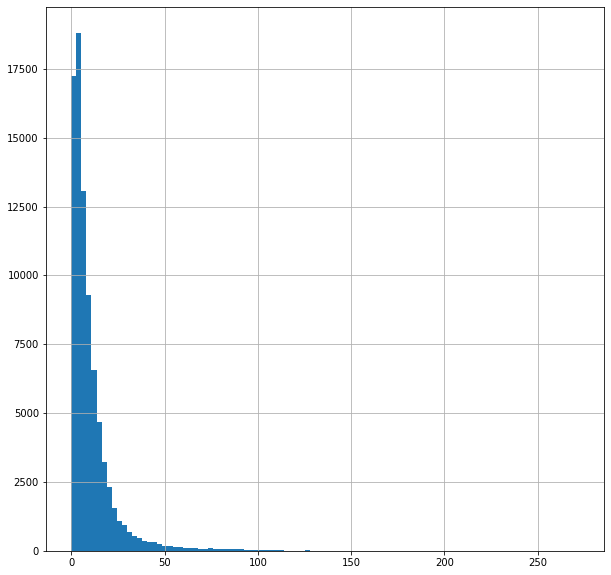

In [15]:
left_side_pred = predict_crossval(crossval_res_left, new_test_df)
left_side_pred[left_side_pred < 0] = 0
left_side_pred

# Train right side

In [16]:
new_train_df = tr_train_df[tr_train_df['Sales'] > SIDE_THRESHOLD].copy()
# new_train_df = tr_train_df

new_test_df = tr_test_df.copy()

print('Data shapes: ')
print(new_train_df.shape)
print(new_test_df.shape)

crossval_res_right = train_simple_split(new_train_df, seed=42)
# crossval_res = train_crossvalidation(new_train_df, seed=42)
crossval_res_right

Data shapes: 
(11557, 61)
(83531, 61)
Learning rate set to 0.031767
0:	learn: 263.1554318	total: 58ms	remaining: 2m 24s
1000:	learn: 130.6505389	total: 54.7s	remaining: 1m 21s
2000:	learn: 115.8201099	total: 1m 47s	remaining: 26.9s
2499:	learn: 110.0550841	total: 2m 15s	remaining: 0us
MSE train: 14188.623242813914, MSE val: 23422.97103596953


{'estimators': [<catboost.core.CatBoostRegressor at 0x7f7a7d8da390>],
 'mse': [23422.97103596953]}

Index(['Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments', 'Rating',
       'Days in stock', 'Delta price', 'SalesDays', 'RatingBrandMedian',
       'cat1', 'cat3', 'cat4', 'cat5', 'second_cat2', 'first_name',
       'second_name', 'Name_TFIDF', 'v1_cluster', 'v2_cluster',
       'mean_Brand_Average price', 'max_Brand_Average price',
       'median_Brand_Average price', 'max_Brand_Rating', 'max_Brand_Comments',
       'median_Brand_Comments', 'count_Brand_Days in stock',
       'max_Seller_Average price', 'median_Seller_Average price',
       'count_Seller_Average price', 'mean_Seller_Rating', 'max_Seller_Rating',
       'median_Seller_Rating', 'max_Seller_Comments', 'median_Seller_Comments',
       'mean_Seller_Days in stock', 'max_Seller_Days in stock',
       'median_Seller_Days in stock', 'count_Seller_Days in stock',
       'mean_cat1_Average price', 'max_cat1_Average price',
       'median_cat1_Average price', 'count_cat1_Average price',
       'max_cat1_Rating', 'median

array([720.72717189, 697.90050003, 749.62277786, ..., 704.35606073,
       769.43505587, 629.11181562])

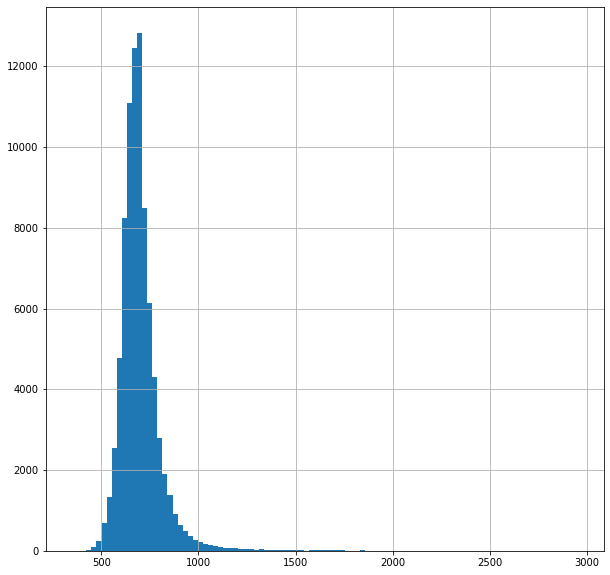

In [17]:
right_side_pred = predict_crossval(crossval_res_right, new_test_df)
right_side_pred[right_side_pred < 0] = 0
right_side_pred

# Train side classifier

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

SEED = 42


df_folds = tr_train_df.copy()

df_folds.loc[df_folds['Sales'] <= SIDE_THRESHOLD, 'Sales'] = 0
df_folds.loc[df_folds['Sales'] > SIDE_THRESHOLD, 'Sales'] = 1

catboost_params = {
    'cat_features': list(df_folds.select_dtypes('object').columns), 
    'task_type': 'GPU',
    'verbose': 1000,
    'random_seed': SEED,
    'iterations': 4000, # 2000
    'eval_metric': 'F1',
    'class_weights': [0.3, 0.7]
}

train_data, val_data = train_test_split(df_folds, test_size=0.1, random_state=SEED)

y_val = val_data.Sales
y_train = train_data.Sales

X_train = train_data.drop(columns=['index', 'Sales'])
X_val = val_data.drop(columns=['index', 'Sales'])
model = CatBoostClassifier(**catboost_params)

model.fit(X_train, y=y_train, eval_set=(X_val, y_val))


y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

train_f1 = f1_score(y_train, y_pred_train)
val_f1 = f1_score(y_val, y_pred_val)

print(f'Fscore train: {train_f1}, Fscore val: {val_f1}')

side_classifiers = {'fscore': [val_f1], 'estimators': [model]}
side_classifiers

Learning rate set to 0.023051
0:	learn: 0.5792610	test: 0.5900110	best: 0.5900110 (0)	total: 72.3ms	remaining: 4m 48s
1000:	learn: 0.7988461	test: 0.8021947	best: 0.8021947 (986)	total: 1m 9s	remaining: 3m 29s
2000:	learn: 0.8102677	test: 0.8078967	best: 0.8098854 (1836)	total: 2m 21s	remaining: 2m 21s
3000:	learn: 0.8195544	test: 0.8106990	best: 0.8106990 (2633)	total: 3m 33s	remaining: 1m 11s
3999:	learn: 0.8274960	test: 0.8115382	best: 0.8125861 (3424)	total: 4m 49s	remaining: 0us
bestTest = 0.8125860628
bestIteration = 3424
Shrink model to first 3425 iterations.
Fscore train: 0.8311584019273238, Fscore val: 0.7748161764705883


{'estimators': [<catboost.core.CatBoostClassifier at 0x7f7a7de87450>],
 'fscore': [0.7748161764705883]}

Text(0, 0.5, 'Precision')

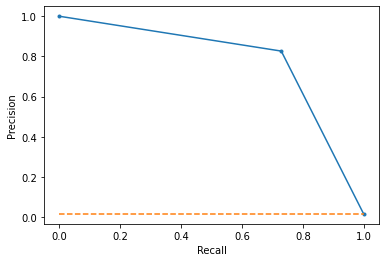

In [8]:
from sklearn.metrics import precision_recall_curve

no_skill = len(y_val[y_val==1]) / len(y_val)
lr_precision, lr_recall, _ = precision_recall_curve(y_val, y_pred_val)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier


def predict_crossval_classifier(crossval_res, tr_test_df):

    tr_test_df = tr_test_df.drop(columns=['Sales', 'index'])

    print(tr_test_df.columns)

    pred_test = ensemble_estimators(crossval_res['estimators'], tr_test_df)

    print(pred_test)

    return pred_test


df_folds = tr_train_df.copy()

df_folds = df_folds.reset_index()

df_folds.loc[df_folds['Sales'] <= SIDE_THRESHOLD, 'Sales'] = 0
df_folds.loc[df_folds['Sales'] > SIDE_THRESHOLD, 'Sales'] = 1


print(df_folds['Sales'].value_counts())
df_folds['Sales'] = df_folds['Sales'].astype('int32')

# create 5 folds
n_splits = 5
skf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
for i_fold, (train_index, test_index) in enumerate(skf.split(df_folds)):
    df_folds.loc[test_index, 'fold'] = i_fold


catboost_params = {
    'cat_features': list(df_folds.select_dtypes('object').columns), 
    'task_type': 'GPU',
    'verbose': 1000,
    'random_seed': SEED,
    'iterations': 2000,
    'eval_metric': 'F1'
}


side_classifiers = {'fscore': [], 'estimators': []}


for fold_number in range(n_splits):

    val_folds = df_folds[df_folds['fold'] == fold_number].drop(columns=['fold', 'index'])
    train_folds = df_folds[df_folds['fold'] != fold_number].drop(columns=['fold', 'index'])

    X_train = train_folds.drop(columns='Sales')
    y_train =  train_folds.Sales

    X_val = val_folds.drop(columns='Sales')
    y_val = val_folds.Sales

    model = CatBoostClassifier(**catboost_params)


    model.fit(X_train, y=y_train, eval_set=(X_val, y_val))

    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_f1 = f1_score(y_train, y_pred_train)
    val_f1 = f1_score(y_val, y_pred_val)

    print(f'Fold {fold_number}')
    print(f'Fscore train: {train_f1}, Fscore val: {val_f1}')

    side_classifiers['fscore'].append(val_f1)
    side_classifiers['estimators'].append(model)

print('Mean fscore: ', np.mean(side_classifiers['fscore']))

In [45]:
df_folds['Sales'].value_counts()

0    740214
1     11557
Name: Sales, dtype: int64

In [54]:
bad_col = tr_test_df.drop(columns=['Sales', 'index']).iloc[:, 10]
bad_col[bad_col == '8323.0']

Series([], Name: cat1, dtype: object)

In [9]:
def ensemble_estimators(estimators, x_data, mode='mean'):

    y_data = 0
    estimators_count = len(estimators) 
    for model in estimators:
        res = model.predict(x_data)
        y_data+=res

    return y_data / estimators_count

def predict_crossval_classifier(crossval_res, tr_test_df):

    tr_test_df = tr_test_df.drop(columns=['Sales', 'index'])

    print(tr_test_df.columns)

    pred_test = ensemble_estimators(crossval_res['estimators'], tr_test_df)

    print(pred_test)

    return pred_test

pred_class = predict_crossval_classifier(side_classifiers, tr_test_df)

pred_class[pred_class > 0.7] = 1
pred_class[pred_class <= 0.7] = 0

df_class = pd.DataFrame()
df_class['val'] = pred_class
df_class['val'].value_counts()

Index(['Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments', 'Rating',
       'Days in stock', 'Delta price', 'SalesDays', 'RatingBrandMedian',
       'cat1', 'cat3', 'cat4', 'cat5', 'second_cat2', 'first_name',
       'second_name', 'Name_TFIDF', 'v1_cluster', 'v2_cluster',
       'mean_Brand_Average price', 'max_Brand_Average price',
       'median_Brand_Average price', 'max_Brand_Rating', 'max_Brand_Comments',
       'median_Brand_Comments', 'count_Brand_Days in stock',
       'max_Seller_Average price', 'median_Seller_Average price',
       'count_Seller_Average price', 'mean_Seller_Rating', 'max_Seller_Rating',
       'median_Seller_Rating', 'max_Seller_Comments', 'median_Seller_Comments',
       'mean_Seller_Days in stock', 'max_Seller_Days in stock',
       'median_Seller_Days in stock', 'count_Seller_Days in stock',
       'mean_cat1_Average price', 'max_cat1_Average price',
       'median_cat1_Average price', 'count_cat1_Average price',
       'max_cat1_Rating', 'median

0.0    82372
1.0     1159
Name: val, dtype: int64

# Create sumbission

In [18]:
(pred_class == 1).sum()

1159

array([ 7.00331889, 20.79970264, 89.84067306, ...,  8.28546863,
        4.00288013,  6.15069163])

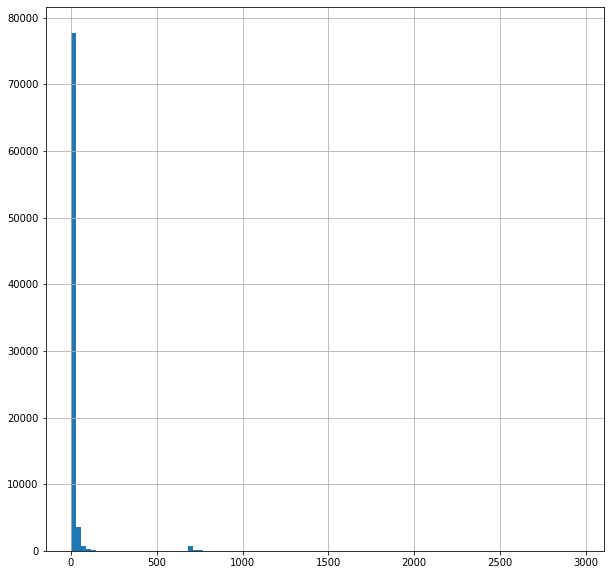

In [19]:
pred_test = left_side_pred.copy()
pred_test[pred_class == 1] = right_side_pred[pred_class == 1]
pred_test[pred_test < 0.0] = 0.0

tr_test_df['Sales'] = pred_test
plt.figure(figsize=(10, 10))
tr_test_df['Sales'].hist(bins=100)

submission = pd.DataFrame({'Id': range(len(pred_test)), 'Expected': pred_test})
submission.to_csv('submission.csv', index=False)

pred_test

In [118]:
len(new_test_df.columns), len(new_train_df.columns)

(110, 111)

In [ ]:
list(new_test_df.columns) ==list(new_train_df.columns)

for z1, z2 in zip(new_test_df, new_train_df):
    print(z1, z2)

Index(['Category', 'Brand', 'Seller', 'Deliveryscheme', 'Comments', 'Rating',
       'Average price', 'Days in stock', 'Delta price', 'RatioPrice',
       ...
       'Comments_mul_Days in stock', 'Comments_sum_Days in stock',
       'Days in stock_mul_Average price', 'Days in stock_sum_Average price',
       'Days in stock_mul_Rating', 'Days in stock_sum_Rating',
       'Days in stock_mul_Comments', 'Days in stock_sum_Comments',
       'Days in stock_mul_Days in stock', 'Days in stock_sum_Days in stock'],
      dtype='object', length=146)
[ 5.63326351 31.18043285 87.32007968 ...  7.77078587  3.22328938
  6.22965582]


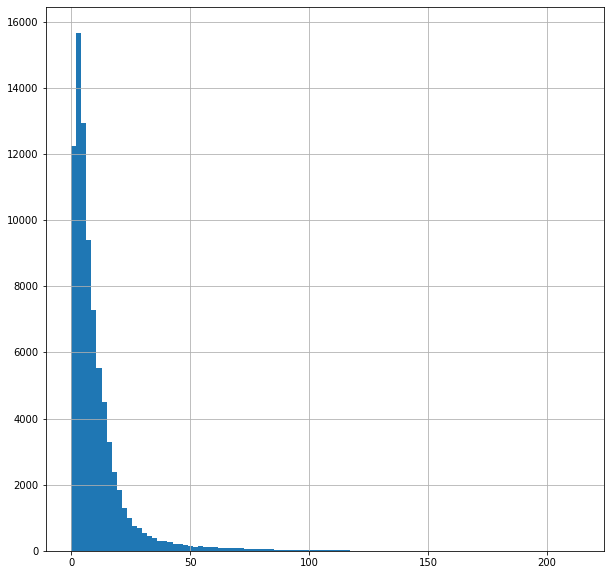

In [30]:
predict_crossval(crossval_res, new_test_df)

In [ ]:
predict_crossval(GLOBAL_CROSSVAL, new_test_df)

In [20]:
!kaggle competitions submit -c nsu-abmd-2021-e-commerce -f submission.csv -m "new flow, side"

100% 1.91M/1.91M [00:02<00:00, 686kB/s]
Successfully submitted to NSU BDA. 2021. E-commerce sales prediction

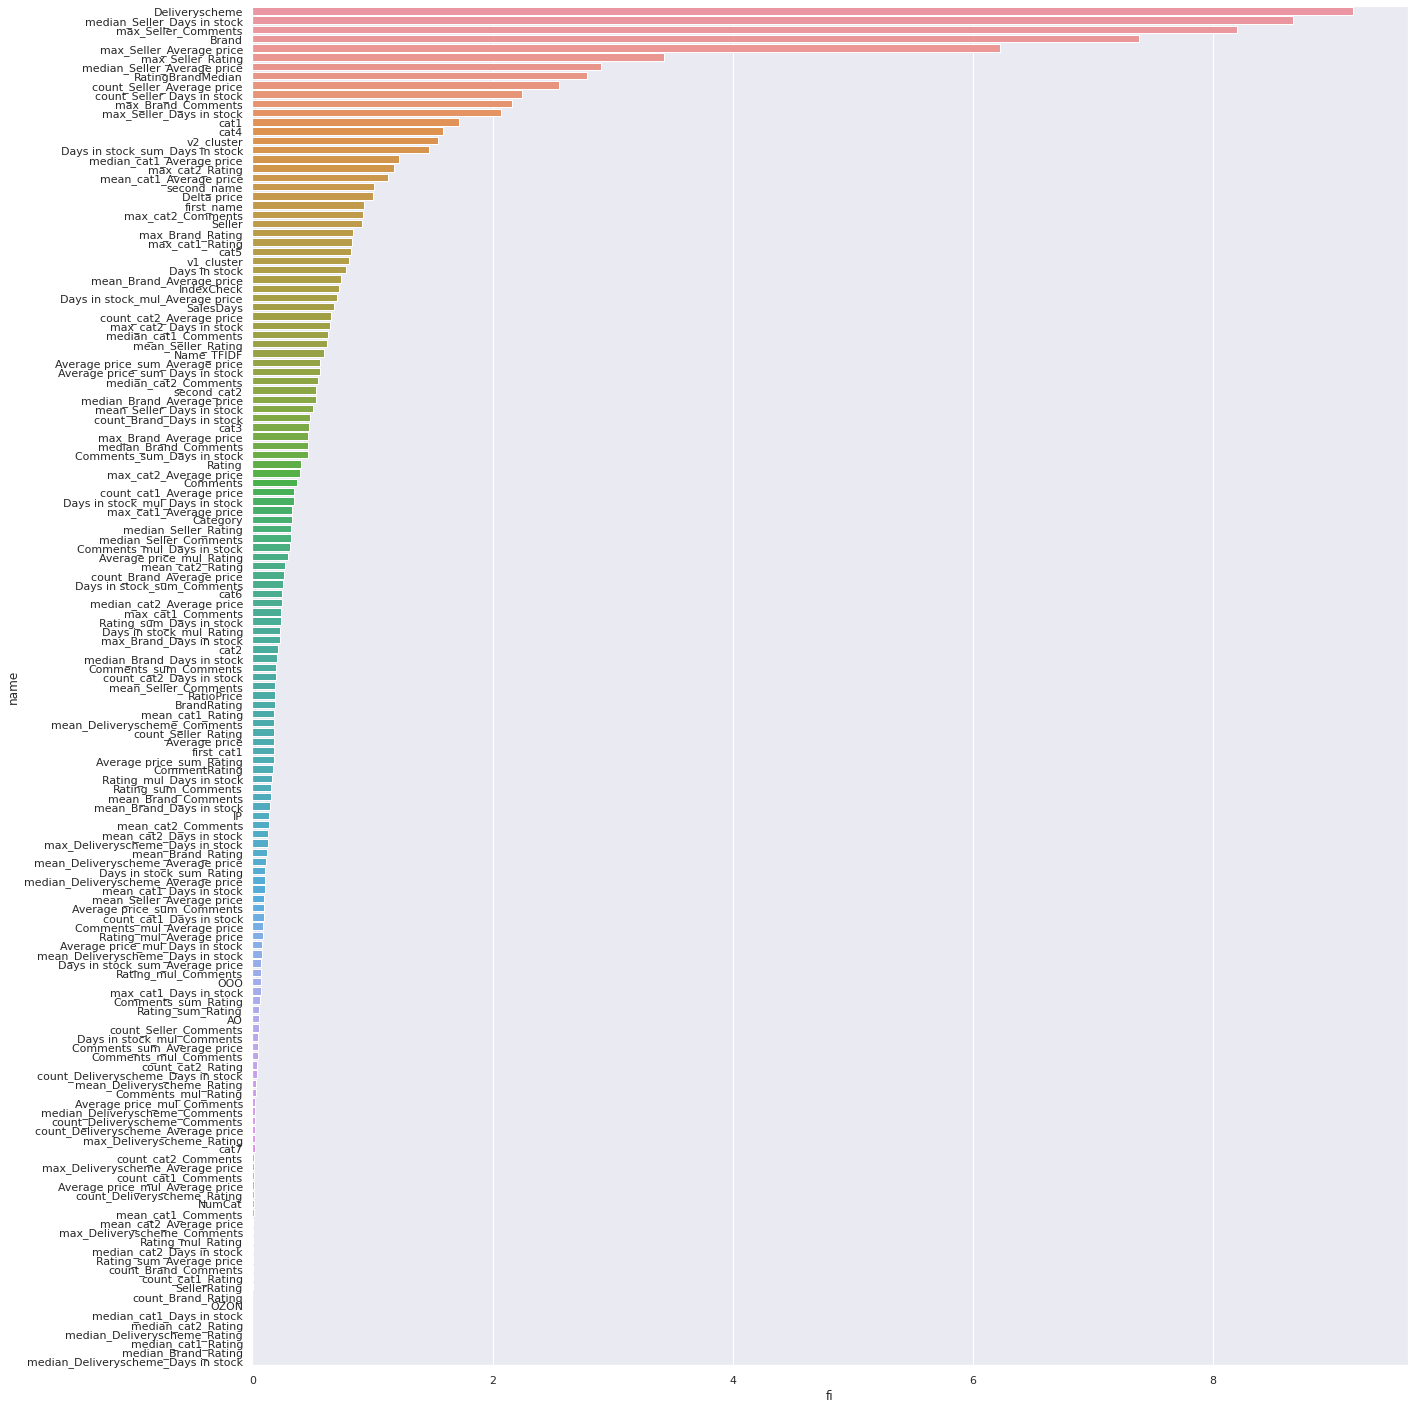

In [21]:
import seaborn as sns

model = GLOBAL_CROSSVAL['estimators'][0]
feature_names = tr_train_df.drop(columns=['Sales', 'index']).columns

fi = pd.DataFrame({'name': feature_names, 'fi': model.feature_importances_})

fi.sort_values(by='fi', ascending=False, inplace=True)

sns.set(rc={'figure.figsize':(20.7,25)})
sns.barplot(x='fi', y='name', data=fi, orient='h')

In [ ]:
bad_features = sorted(np.load('./data/feature_import_v2.npy'), key=lambda x: x[1], reverse=True)[10:] # prev 60, 40
bad_features_names = list(map(lambda x: x[0], bad_features))

tr_train_df = tr_train_df.drop(columns=bad_features_names)
tr_test_df = tr_test_df.drop(columns=bad_features_names)

print(bad_features_names)
len(tr_train_df.columns), len(tr_test_df.columns)

In [22]:
np.save('feature_import_v2.npy', list(zip(feature_names, model.feature_importances_)))

**INSPECT ERRORS**

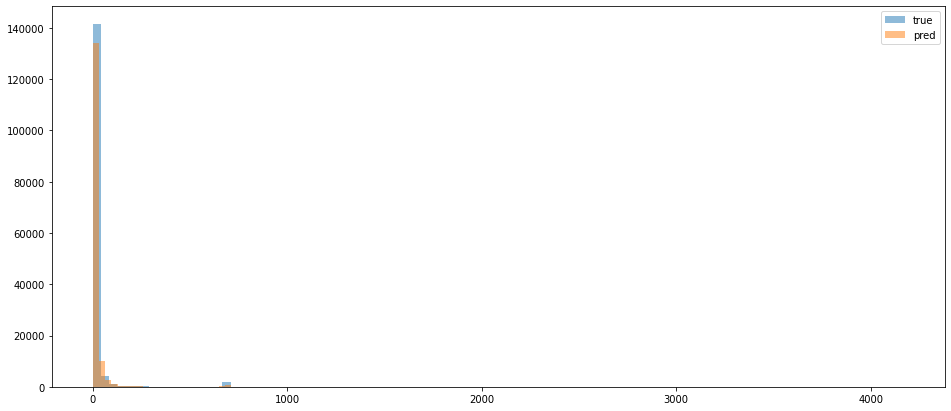

In [10]:
zero_fold = VAL_FOLDS[0]

X_val = zero_fold.drop(columns='Sales')
y_val = zero_fold.Sales

val_result = GLOBAL_CROSSVAL['estimators'][0].predict(X_val)

val_result[val_result < 0] = 0

plt.figure(figsize=(16, 7))
plt.hist(y_val, 100, alpha=0.5, label='true')
plt.hist(val_result, 100, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

<Figure size 432x288 with 0 Axes>

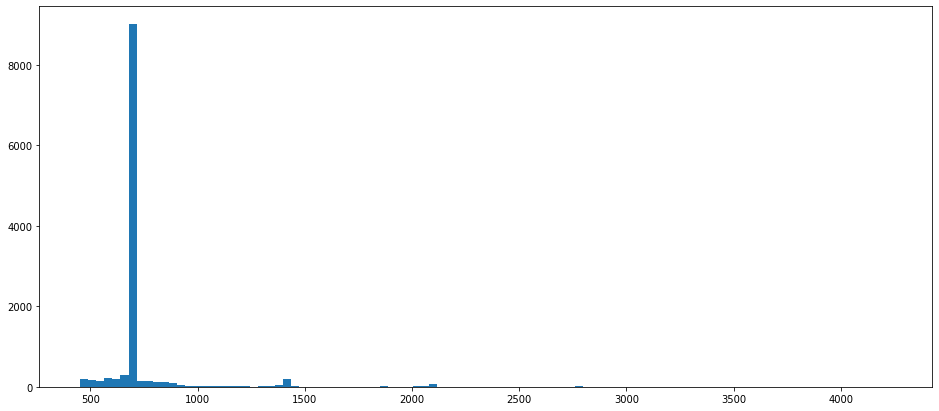

In [19]:
plt.figure()
plt.figure(figsize=(16, 7))
plt.hist(df[df['Sales'] > 450]['Sales'], bins=100);

<Figure size 432x288 with 0 Axes>

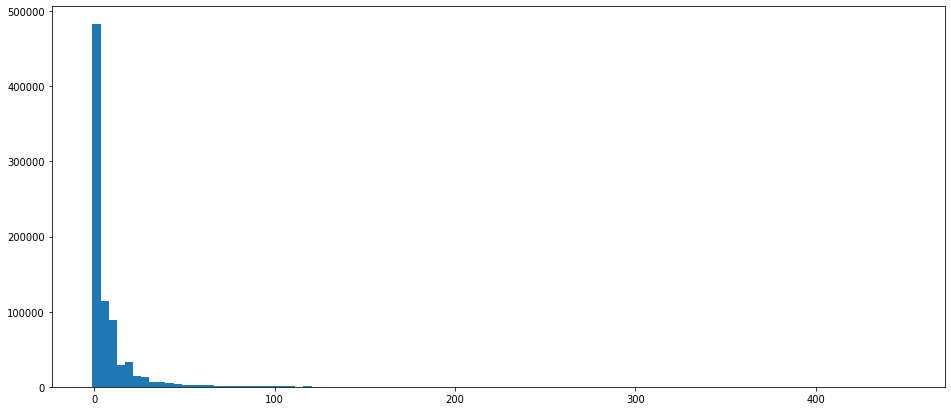

In [20]:
plt.figure()
plt.figure(figsize=(16, 7))
plt.hist(df[df['Sales'] < 450]['Sales'], bins=100);

# Autogluon

In [ ]:
!pip install autogluon.tabular[all]

In [5]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [6]:
subs = pd.read_csv("data/submission_example.csv")
subs.head(5)

,Id,Expected
0,0,4
1,1,6
2,2,1
3,3,1
4,4,4


In [90]:
tr_train_df.shape, test_final.shape

((751771, 83), (83531, 83))

In [91]:
RANDOM_STATE = 228
RUNTIME = 3600 * 2 # 3600 in seconds
N_FOLDS = 5

y = "Sales"

In [92]:
predictor = TabularPredictor(label=y, eval_metric='mse', path='./', verbosity=3).fit(tr_train_df, presets='best_quality', time_limit=RUNTIME, ag_args_fit={'num_gpus': 1})

Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'ag_args_fit': {'num_gpus': 1}, 'auto_stack': True}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': {'num_gpus': 1},
 'auto_stack': True,
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': None,
 'keep_only_best': False,
 'num_bag_folds': None,
 'num_bag_sets': None,
 'num_stack_levels': None,
 'quantile_levels': None,
 'refit_full': False,
 'save_space': False,
 'set_best_to_refit_full': False,
 'unlabeled_data': None,
 'use_bag_holdout': False,
 'verbosity': 3}
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "./"
AutoGluon Version:  0.3.1
Train Data Rows:    751771
Train Data Columns: 82
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == f

[50]	train_set's l2: 3704.9	valid_set's l2: 3889.13
[100]	train_set's l2: 3254.07	valid_set's l2: 3548.51
[150]	train_set's l2: 3048.68	valid_set's l2: 3432.5
[200]	train_set's l2: 2916.69	valid_set's l2: 3356.38
[250]	train_set's l2: 2807.17	valid_set's l2: 3299.79
[300]	train_set's l2: 2725.82	valid_set's l2: 3258.23
[350]	train_set's l2: 2652.43	valid_set's l2: 3233.82
[400]	train_set's l2: 2594.21	valid_set's l2: 3213.73
[450]	train_set's l2: 2543.05	valid_set's l2: 3187.14
[500]	train_set's l2: 2491.62	valid_set's l2: 3166.56
[550]	train_set's l2: 2446.65	valid_set's l2: 3153.84
[600]	train_set's l2: 2406.46	valid_set's l2: 3138.4
[650]	train_set's l2: 2371.86	valid_set's l2: 3126.97
[700]	train_set's l2: 2336.37	valid_set's l2: 3112.75
[750]	train_set's l2: 2303.52	valid_set's l2: 3106.09
[800]	train_set's l2: 2271.69	valid_set's l2: 3101.79
[850]	train_set's l2: 2242.41	valid_set's l2: 3091.99
[900]	train_set's l2: 2213.27	valid_set's l2: 3086.37
[950]	train_set's l2: 2185.42	va

	Ran out of time, early stopping on iteration 3861. Best iteration is:
	[3849]	train_set's l2: 1443.49	valid_set's l2: 2937.88
	Fitting S1F2 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3673.75	valid_set's l2: 3737.27
[100]	train_set's l2: 3242.2	valid_set's l2: 3440.65
[150]	train_set's l2: 3041.06	valid_set's l2: 3331.57
[200]	train_set's l2: 2907.97	valid_set's l2: 3273.46
[250]	train_set's l2: 2806.76	valid_set's l2: 3217.03
[300]	train_set's l2: 2734.92	valid_set's l2: 3189.36
[350]	train_set's l2: 2663.11	valid_set's l2: 3153.39
[400]	train_set's l2: 2601.21	valid_set's l2: 3130.09
[450]	train_set's l2: 2545.53	valid_set's l2: 3107.77
[500]	train_set's l2: 2495.62	valid_set's l2: 3087.7
[550]	train_set's l2: 2452.54	valid_set's l2: 3073.28
[600]	train_set's l2: 2413.3	valid_set's l2: 3060.21
[650]	train_set's l2: 2374.87	valid_set's l2: 3050.94
[700]	train_set's l2: 2334.33	valid_set's l2: 3033.63
[750]	train_set's l2: 2298.64	valid_set's l2: 3023.13
[800]	train_set's l2: 2267.95	valid_set's l2: 3012.58
[850]	train_set's l2: 2236.9	valid_set's l2: 3001.12
[900]	train_set's l2: 2207.87	valid_set's l2: 2995.97
[950]	train_set's l2: 2179.16	val

	Ran out of time, early stopping on iteration 3949. Best iteration is:
	[3895]	train_set's l2: 1453.66	valid_set's l2: 2813.56
	Fitting S1F3 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3673.49	valid_set's l2: 3694.54
[100]	train_set's l2: 3264.55	valid_set's l2: 3413.64
[150]	train_set's l2: 3055.86	valid_set's l2: 3285.28
[200]	train_set's l2: 2924.53	valid_set's l2: 3211.55
[250]	train_set's l2: 2820.64	valid_set's l2: 3158.76
[300]	train_set's l2: 2737.12	valid_set's l2: 3125.34
[350]	train_set's l2: 2669.01	valid_set's l2: 3103.67
[400]	train_set's l2: 2609.3	valid_set's l2: 3078.95
[450]	train_set's l2: 2556.99	valid_set's l2: 3058.37
[500]	train_set's l2: 2508.16	valid_set's l2: 3040.78
[550]	train_set's l2: 2466.45	valid_set's l2: 3024.55
[600]	train_set's l2: 2422.4	valid_set's l2: 3007.7
[650]	train_set's l2: 2385.02	valid_set's l2: 2996.04
[700]	train_set's l2: 2349.03	valid_set's l2: 2986.8
[750]	train_set's l2: 2310.98	valid_set's l2: 2972.79
[800]	train_set's l2: 2278.99	valid_set's l2: 2961.73
[850]	train_set's l2: 2247.03	valid_set's l2: 2953.67
[900]	train_set's l2: 2215.4	valid_set's l2: 2948.46
[950]	train_set's l2: 2188.46	vali

	Ran out of time, early stopping on iteration 4096. Best iteration is:
	[3738]	train_set's l2: 1454.63	valid_set's l2: 2816.34
	Fitting S1F4 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3642.72	valid_set's l2: 4104.84
[100]	train_set's l2: 3239.78	valid_set's l2: 3796.48
[150]	train_set's l2: 3021.55	valid_set's l2: 3667.3
[200]	train_set's l2: 2880.65	valid_set's l2: 3590.4
[250]	train_set's l2: 2779.58	valid_set's l2: 3536.7
[300]	train_set's l2: 2698.97	valid_set's l2: 3503.72
[350]	train_set's l2: 2628.1	valid_set's l2: 3470.49
[400]	train_set's l2: 2564.26	valid_set's l2: 3453.75
[450]	train_set's l2: 2511.42	valid_set's l2: 3427.98
[500]	train_set's l2: 2462.14	valid_set's l2: 3406.75
[550]	train_set's l2: 2414.35	valid_set's l2: 3388.71
[600]	train_set's l2: 2369.89	valid_set's l2: 3374.95
[650]	train_set's l2: 2331.15	valid_set's l2: 3364.42
[700]	train_set's l2: 2296.14	valid_set's l2: 3354.05
[750]	train_set's l2: 2262.01	valid_set's l2: 3341.08
[800]	train_set's l2: 2233.24	valid_set's l2: 3331.94
[850]	train_set's l2: 2203.09	valid_set's l2: 3316.93
[900]	train_set's l2: 2173.45	valid_set's l2: 3305.45
[950]	train_set's l2: 2144.12	val

	Ran out of time, early stopping on iteration 4296. Best iteration is:
	[4296]	train_set's l2: 1366.87	valid_set's l2: 3120.33
	Fitting S1F5 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3677.8	valid_set's l2: 3955.41
[100]	train_set's l2: 3220.77	valid_set's l2: 3653.16
[150]	train_set's l2: 3007.43	valid_set's l2: 3538.6
[200]	train_set's l2: 2875.32	valid_set's l2: 3474.48
[250]	train_set's l2: 2774.72	valid_set's l2: 3423.59
[300]	train_set's l2: 2698.79	valid_set's l2: 3390.53
[350]	train_set's l2: 2630.36	valid_set's l2: 3360.1
[400]	train_set's l2: 2574.89	valid_set's l2: 3335.01
[450]	train_set's l2: 2520.49	valid_set's l2: 3314.75
[500]	train_set's l2: 2469.24	valid_set's l2: 3299.25
[550]	train_set's l2: 2425.14	valid_set's l2: 3286.08
[600]	train_set's l2: 2386.45	valid_set's l2: 3275.18
[650]	train_set's l2: 2345.62	valid_set's l2: 3260.65
[700]	train_set's l2: 2313.7	valid_set's l2: 3247.2
[750]	train_set's l2: 2279.31	valid_set's l2: 3235.79
[800]	train_set's l2: 2248.31	valid_set's l2: 3225.27
[850]	train_set's l2: 2216.43	valid_set's l2: 3213.65
[900]	train_set's l2: 2189.5	valid_set's l2: 3205.51
[950]	train_set's l2: 2161.91	valid

	Ran out of time, early stopping on iteration 4459. Best iteration is:
	[4449]	train_set's l2: 1364.19	valid_set's l2: 2987.09
	Fitting S1F6 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F6 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3702.8	valid_set's l2: 3523.28
[100]	train_set's l2: 3250.92	valid_set's l2: 3234.37
[150]	train_set's l2: 3050.28	valid_set's l2: 3131.06
[200]	train_set's l2: 2916.78	valid_set's l2: 3076.36
[250]	train_set's l2: 2816.76	valid_set's l2: 3027.59
[300]	train_set's l2: 2732.14	valid_set's l2: 2988.45
[350]	train_set's l2: 2664.32	valid_set's l2: 2962.49
[400]	train_set's l2: 2600.25	valid_set's l2: 2939.34
[450]	train_set's l2: 2545.9	valid_set's l2: 2920.27
[500]	train_set's l2: 2493.91	valid_set's l2: 2908.6
[550]	train_set's l2: 2443.02	valid_set's l2: 2895.07
[600]	train_set's l2: 2402.53	valid_set's l2: 2882.6
[650]	train_set's l2: 2363.16	valid_set's l2: 2869.27
[700]	train_set's l2: 2330.05	valid_set's l2: 2858.98
[750]	train_set's l2: 2294.69	valid_set's l2: 2848.95
[800]	train_set's l2: 2261.43	valid_set's l2: 2839.37
[850]	train_set's l2: 2230.49	valid_set's l2: 2825.91
[900]	train_set's l2: 2205.33	valid_set's l2: 2821.89
[950]	train_set's l2: 2176.38	val

	Ran out of time, early stopping on iteration 4345. Best iteration is:
	[4338]	train_set's l2: 1390.57	valid_set's l2: 2681.43
	Fitting S1F7 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F7 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3694.75	valid_set's l2: 3901.97
[100]	train_set's l2: 3273.32	valid_set's l2: 3615.47
[150]	train_set's l2: 3066.27	valid_set's l2: 3487.57
[200]	train_set's l2: 2930.62	valid_set's l2: 3413.38
[250]	train_set's l2: 2828.14	valid_set's l2: 3355.59
[300]	train_set's l2: 2745.31	valid_set's l2: 3314.95
[350]	train_set's l2: 2676.7	valid_set's l2: 3278.53
[400]	train_set's l2: 2621.18	valid_set's l2: 3252.11
[450]	train_set's l2: 2565.66	valid_set's l2: 3229.79
[500]	train_set's l2: 2521.04	valid_set's l2: 3210.38
[550]	train_set's l2: 2478.83	valid_set's l2: 3195.47
[600]	train_set's l2: 2438.56	valid_set's l2: 3182.12
[650]	train_set's l2: 2401.55	valid_set's l2: 3164.93
[700]	train_set's l2: 2363.06	valid_set's l2: 3151.01
[750]	train_set's l2: 2329.29	valid_set's l2: 3138.14
[800]	train_set's l2: 2297.17	valid_set's l2: 3125.62
[850]	train_set's l2: 2266.19	valid_set's l2: 3109.9
[900]	train_set's l2: 2236.6	valid_set's l2: 3099.57
[950]	train_set's l2: 2211.63	va

	Ran out of time, early stopping on iteration 4570. Best iteration is:
	[4556]	train_set's l2: 1375.18	valid_set's l2: 2891.88
	Fitting S1F8 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F8 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3651.43	valid_set's l2: 4052.38
[100]	train_set's l2: 3245.81	valid_set's l2: 3727.89
[150]	train_set's l2: 3044.88	valid_set's l2: 3583.99
[200]	train_set's l2: 2909.45	valid_set's l2: 3493.1
[250]	train_set's l2: 2807.62	valid_set's l2: 3432.48
[300]	train_set's l2: 2729.5	valid_set's l2: 3383.89
[350]	train_set's l2: 2659.41	valid_set's l2: 3347.23
[400]	train_set's l2: 2598.62	valid_set's l2: 3321.78
[450]	train_set's l2: 2543.74	valid_set's l2: 3294.25
[500]	train_set's l2: 2497.06	valid_set's l2: 3271.98
[550]	train_set's l2: 2451.96	valid_set's l2: 3246.4
[600]	train_set's l2: 2410.73	valid_set's l2: 3228.21
[650]	train_set's l2: 2371.36	valid_set's l2: 3214.11
[700]	train_set's l2: 2330.17	valid_set's l2: 3204.44
[750]	train_set's l2: 2295.32	valid_set's l2: 3194.38
[800]	train_set's l2: 2264.17	valid_set's l2: 3180.17
[850]	train_set's l2: 2236.23	valid_set's l2: 3169.79
[900]	train_set's l2: 2208.59	valid_set's l2: 3158.99
[950]	train_set's l2: 2181.65	va

	Ran out of time, early stopping on iteration 4978. Best iteration is:
	[4977]	train_set's l2: 1303.92	valid_set's l2: 2949.01
	Fitting S1F9 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F9 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3652.49	valid_set's l2: 3799.9
[100]	train_set's l2: 3250.83	valid_set's l2: 3483.26
[150]	train_set's l2: 3049.56	valid_set's l2: 3361.7
[200]	train_set's l2: 2915.68	valid_set's l2: 3282.53
[250]	train_set's l2: 2811.2	valid_set's l2: 3233.49
[300]	train_set's l2: 2727.61	valid_set's l2: 3202.23
[350]	train_set's l2: 2660.73	valid_set's l2: 3171.64
[400]	train_set's l2: 2598.11	valid_set's l2: 3140.62
[450]	train_set's l2: 2543.63	valid_set's l2: 3112.45
[500]	train_set's l2: 2493.33	valid_set's l2: 3087
[550]	train_set's l2: 2448.31	valid_set's l2: 3066.88
[600]	train_set's l2: 2404.24	valid_set's l2: 3050.74
[650]	train_set's l2: 2368.1	valid_set's l2: 3037.32
[700]	train_set's l2: 2332.54	valid_set's l2: 3018.71
[750]	train_set's l2: 2300.05	valid_set's l2: 3000.34
[800]	train_set's l2: 2267.7	valid_set's l2: 2990.34
[850]	train_set's l2: 2235.17	valid_set's l2: 2978.31
[900]	train_set's l2: 2205.39	valid_set's l2: 2968.22
[950]	train_set's l2: 2180.43	valid_s

	Ran out of time, early stopping on iteration 5418. Best iteration is:
	[5400]	train_set's l2: 1261.59	valid_set's l2: 2788.97
	Fitting S1F10 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F10 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3679.84	valid_set's l2: 4113.59
[100]	train_set's l2: 3275.03	valid_set's l2: 3762.46
[150]	train_set's l2: 3064.57	valid_set's l2: 3617.88
[200]	train_set's l2: 2931.22	valid_set's l2: 3541.24
[250]	train_set's l2: 2826.8	valid_set's l2: 3485.91
[300]	train_set's l2: 2739.73	valid_set's l2: 3427.94
[350]	train_set's l2: 2674.64	valid_set's l2: 3392.72
[400]	train_set's l2: 2613.96	valid_set's l2: 3363.2
[450]	train_set's l2: 2559.71	valid_set's l2: 3339.88
[500]	train_set's l2: 2514.49	valid_set's l2: 3316.2
[550]	train_set's l2: 2472.19	valid_set's l2: 3286.66
[600]	train_set's l2: 2431.08	valid_set's l2: 3266.86
[650]	train_set's l2: 2395.89	valid_set's l2: 3256.08
[700]	train_set's l2: 2359.92	valid_set's l2: 3238.48
[750]	train_set's l2: 2327.51	valid_set's l2: 3225.36
[800]	train_set's l2: 2297.08	valid_set's l2: 3218.49
[850]	train_set's l2: 2266.46	valid_set's l2: 3204.67
[900]	train_set's l2: 2239.37	valid_set's l2: 3200.56
[950]	train_set's l2: 2214.36	va

	Ran out of time, early stopping on iteration 6295. Best iteration is:
	[6295]	train_set's l2: 1198.26	valid_set's l2: 2944.69
Saving ./models/LightGBMXT_BAG_L1/utils/oof.pkl
Saving ./models/LightGBMXT_BAG_L1/model.pkl
	-2893.1192	 = Validation score   (mean_squared_error)
	4294.07s	 = Training   runtime
	188.09s	 = Validation runtime
Saving ./models/trainer.pkl
Fitting model: LightGBM_BAG_L1 ... Training model for up to 99.7s of the 2416.95s of remaining time.
Saving ./models/LightGBM_BAG_L1/utils/model_template.pkl
	Fitting S1F1 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose

[50]	train_set's l2: 3329.61	valid_set's l2: 3590.09
[100]	train_set's l2: 2939.75	valid_set's l2: 3332.56
[150]	train_set's l2: 2765.2	valid_set's l2: 3244.94
[200]	train_set's l2: 2642.33	valid_set's l2: 3183.83
[250]	train_set's l2: 2545.86	valid_set's l2: 3137.34
[300]	train_set's l2: 2464.2	valid_set's l2: 3103.83
[350]	train_set's l2: 2401.79	valid_set's l2: 3079.83
[400]	train_set's l2: 2347.45	valid_set's l2: 3067.48
[450]	train_set's l2: 2290.87	valid_set's l2: 3053.44
[500]	train_set's l2: 2241.29	valid_set's l2: 3046.32
[550]	train_set's l2: 2199.7	valid_set's l2: 3035.02
[600]	train_set's l2: 2165.11	valid_set's l2: 3027.74
[650]	train_set's l2: 2130.93	valid_set's l2: 3025.09
[700]	train_set's l2: 2097.66	valid_set's l2: 3024.05
[750]	train_set's l2: 2063.69	valid_set's l2: 3017.29
[800]	train_set's l2: 2035.35	valid_set's l2: 3015.19
[850]	train_set's l2: 2007.64	valid_set's l2: 3011.6
[900]	train_set's l2: 1982.46	valid_set's l2: 3010.37
[950]	train_set's l2: 1955.86	val

	Ran out of time, early stopping on iteration 1561. Best iteration is:
	[1557]	train_set's l2: 1701.81	valid_set's l2: 2979.82
	Fitting S1F2 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3297.71	valid_set's l2: 3484.74
[100]	train_set's l2: 2879.17	valid_set's l2: 3217.77
[150]	train_set's l2: 2709.18	valid_set's l2: 3157.75
[200]	train_set's l2: 2602.77	valid_set's l2: 3135.97
[250]	train_set's l2: 2507.73	valid_set's l2: 3102.15
[300]	train_set's l2: 2440.57	valid_set's l2: 3087.08
[350]	train_set's l2: 2388.19	valid_set's l2: 3084.17
[400]	train_set's l2: 2338.39	valid_set's l2: 3078.15
[450]	train_set's l2: 2289.37	valid_set's l2: 3058.89
[500]	train_set's l2: 2243.82	valid_set's l2: 3049.02
[550]	train_set's l2: 2207.68	valid_set's l2: 3049.24
[600]	train_set's l2: 2173.69	valid_set's l2: 3040.89
[650]	train_set's l2: 2137	valid_set's l2: 3036.16
[700]	train_set's l2: 2107.06	valid_set's l2: 3031.45
[750]	train_set's l2: 2074.12	valid_set's l2: 3026.41
[800]	train_set's l2: 2043.33	valid_set's l2: 3023.94
[850]	train_set's l2: 2014.64	valid_set's l2: 3015.29
[900]	train_set's l2: 1989.17	valid_set's l2: 3012.25
[950]	train_set's l2: 1959.46	va

	Ran out of time, early stopping on iteration 1652. Best iteration is:
	[1652]	train_set's l2: 1664.67	valid_set's l2: 2973.87


[1650]	train_set's l2: 1665.28	valid_set's l2: 2973.98


	Fitting S1F3 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3279.14	valid_set's l2: 3522.86
[100]	train_set's l2: 2914.91	valid_set's l2: 3259.25
[150]	train_set's l2: 2759.52	valid_set's l2: 3176.2
[200]	train_set's l2: 2630.39	valid_set's l2: 3109.3
[250]	train_set's l2: 2533.12	valid_set's l2: 3075.8
[300]	train_set's l2: 2452.38	valid_set's l2: 3043.1
[350]	train_set's l2: 2394.75	valid_set's l2: 3033.37
[400]	train_set's l2: 2341.66	valid_set's l2: 3022.78
[450]	train_set's l2: 2293.01	valid_set's l2: 3016.3
[500]	train_set's l2: 2251.2	valid_set's l2: 3009.13
[550]	train_set's l2: 2209.33	valid_set's l2: 3004.76
[600]	train_set's l2: 2163.66	valid_set's l2: 2992.79
[650]	train_set's l2: 2129.12	valid_set's l2: 2988.03
[700]	train_set's l2: 2094.92	valid_set's l2: 2985.9
[750]	train_set's l2: 2064.34	valid_set's l2: 2980.23
[800]	train_set's l2: 2028.51	valid_set's l2: 2977.66
[850]	train_set's l2: 2002.36	valid_set's l2: 2978.08
[900]	train_set's l2: 1975.69	valid_set's l2: 2975.03
[950]	train_set's l2: 1951.47	valid_

	Ran out of time, early stopping on iteration 1608. Best iteration is:
	[1607]	train_set's l2: 1679.2	valid_set's l2: 2950.13
	Fitting S1F4 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3457.51	valid_set's l2: 3233.59
[100]	train_set's l2: 3024.3	valid_set's l2: 2911.61
[150]	train_set's l2: 2818.32	valid_set's l2: 2800.59
[200]	train_set's l2: 2690.41	valid_set's l2: 2755.46
[250]	train_set's l2: 2593.13	valid_set's l2: 2728.31
[300]	train_set's l2: 2528.46	valid_set's l2: 2713.15
[350]	train_set's l2: 2461.35	valid_set's l2: 2698.15
[400]	train_set's l2: 2390.34	valid_set's l2: 2674.65
[450]	train_set's l2: 2332.65	valid_set's l2: 2664.7
[500]	train_set's l2: 2288.26	valid_set's l2: 2657.62
[550]	train_set's l2: 2247.01	valid_set's l2: 2653.58
[600]	train_set's l2: 2207.12	valid_set's l2: 2646.9
[650]	train_set's l2: 2167.85	valid_set's l2: 2643.62
[700]	train_set's l2: 2130.64	valid_set's l2: 2643.64
[750]	train_set's l2: 2100.32	valid_set's l2: 2640.71
[800]	train_set's l2: 2069.96	valid_set's l2: 2637.59
[850]	train_set's l2: 2042.48	valid_set's l2: 2640.67
[900]	train_set's l2: 2010.29	valid_set's l2: 2642.75
[950]	train_set's l2: 1983.79	va

	Fitting S1F5 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3370.4	valid_set's l2: 3592.26
[100]	train_set's l2: 2934.53	valid_set's l2: 3279.52
[150]	train_set's l2: 2760.33	valid_set's l2: 3189.48
[200]	train_set's l2: 2636.4	valid_set's l2: 3136.83
[250]	train_set's l2: 2530.03	valid_set's l2: 3102.98
[300]	train_set's l2: 2471.14	valid_set's l2: 3090.97
[350]	train_set's l2: 2402.71	valid_set's l2: 3074.16
[400]	train_set's l2: 2349.39	valid_set's l2: 3068
[450]	train_set's l2: 2295.23	valid_set's l2: 3050.39
[500]	train_set's l2: 2248.75	valid_set's l2: 3043.07
[550]	train_set's l2: 2207.88	valid_set's l2: 3039.93
[600]	train_set's l2: 2166.76	valid_set's l2: 3027.51
[650]	train_set's l2: 2130.11	valid_set's l2: 3023.72
[700]	train_set's l2: 2095.52	valid_set's l2: 3021.11
[750]	train_set's l2: 2065.75	valid_set's l2: 3017.26
[800]	train_set's l2: 2035.98	valid_set's l2: 3015.62
[850]	train_set's l2: 2006.47	valid_set's l2: 3015.92
[900]	train_set's l2: 1980.12	valid_set's l2: 3012.41
[950]	train_set's l2: 1952.6	valid

	Ran out of time, early stopping on iteration 1890. Best iteration is:
	[1890]	train_set's l2: 1584.67	valid_set's l2: 2978.44
	Fitting S1F6 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F6 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3342.6	valid_set's l2: 3513.13
[100]	train_set's l2: 2957.49	valid_set's l2: 3228.23
[150]	train_set's l2: 2774.74	valid_set's l2: 3147.05
[200]	train_set's l2: 2649.23	valid_set's l2: 3104.02
[250]	train_set's l2: 2558.67	valid_set's l2: 3072.25
[300]	train_set's l2: 2476.77	valid_set's l2: 3049.02
[350]	train_set's l2: 2413.65	valid_set's l2: 3036.85
[400]	train_set's l2: 2355.21	valid_set's l2: 3026.05
[450]	train_set's l2: 2301.43	valid_set's l2: 3015.54
[500]	train_set's l2: 2254.37	valid_set's l2: 3014.99
[550]	train_set's l2: 2217.2	valid_set's l2: 3012.06
[600]	train_set's l2: 2179.62	valid_set's l2: 3005.6
[650]	train_set's l2: 2141.33	valid_set's l2: 2994.62
[700]	train_set's l2: 2105.59	valid_set's l2: 2991.79
[750]	train_set's l2: 2073.26	valid_set's l2: 2986
[800]	train_set's l2: 2043.65	valid_set's l2: 2983.37
[850]	train_set's l2: 2015.81	valid_set's l2: 2976.15
[900]	train_set's l2: 1987.16	valid_set's l2: 2972.67
[950]	train_set's l2: 1959.08	valid

	Ran out of time, early stopping on iteration 1948. Best iteration is:
	[1871]	train_set's l2: 1604.36	valid_set's l2: 2931.63
	Fitting S1F7 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F7 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3325.98	valid_set's l2: 3463.62
[100]	train_set's l2: 2951.99	valid_set's l2: 3224.02
[150]	train_set's l2: 2771.06	valid_set's l2: 3129.02
[200]	train_set's l2: 2649.71	valid_set's l2: 3085.76
[250]	train_set's l2: 2560.74	valid_set's l2: 3058.28
[300]	train_set's l2: 2483.42	valid_set's l2: 3034.55
[350]	train_set's l2: 2423.23	valid_set's l2: 3024.81
[400]	train_set's l2: 2361.88	valid_set's l2: 3013.39
[450]	train_set's l2: 2306.48	valid_set's l2: 3000.6
[500]	train_set's l2: 2264.47	valid_set's l2: 2994.35
[550]	train_set's l2: 2222.89	valid_set's l2: 2985.79
[600]	train_set's l2: 2182	valid_set's l2: 2981.41
[650]	train_set's l2: 2142.83	valid_set's l2: 2975.17
[700]	train_set's l2: 2107.12	valid_set's l2: 2969.26
[750]	train_set's l2: 2073.34	valid_set's l2: 2964.51
[800]	train_set's l2: 2044.26	valid_set's l2: 2961.63
[850]	train_set's l2: 2017.86	valid_set's l2: 2961.99
[900]	train_set's l2: 1989.99	valid_set's l2: 2958.15
[950]	train_set's l2: 1960.93	val

	Fitting S1F8 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F8 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3263.56	valid_set's l2: 3928.28
[100]	train_set's l2: 2902.19	valid_set's l2: 3692.92
[150]	train_set's l2: 2739.2	valid_set's l2: 3616.42
[200]	train_set's l2: 2596.03	valid_set's l2: 3559.48
[250]	train_set's l2: 2519.67	valid_set's l2: 3538.27
[300]	train_set's l2: 2439.1	valid_set's l2: 3512.81
[350]	train_set's l2: 2378.99	valid_set's l2: 3496.72
[400]	train_set's l2: 2321.69	valid_set's l2: 3480.42
[450]	train_set's l2: 2273.7	valid_set's l2: 3472.78
[500]	train_set's l2: 2227.01	valid_set's l2: 3463.85
[550]	train_set's l2: 2186.35	valid_set's l2: 3457.75
[600]	train_set's l2: 2150.54	valid_set's l2: 3455.14
[650]	train_set's l2: 2113.29	valid_set's l2: 3452.25
[700]	train_set's l2: 2078.56	valid_set's l2: 3456.02
[750]	train_set's l2: 2047.83	valid_set's l2: 3456.95


	Fitting S1F9 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F9 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3278.91	valid_set's l2: 3777.55
[100]	train_set's l2: 2873.11	valid_set's l2: 3436.69
[150]	train_set's l2: 2709.66	valid_set's l2: 3344.32
[200]	train_set's l2: 2613.74	valid_set's l2: 3288.01
[250]	train_set's l2: 2518.13	valid_set's l2: 3234.53
[300]	train_set's l2: 2451.66	valid_set's l2: 3215.05
[350]	train_set's l2: 2399.47	valid_set's l2: 3199.49
[400]	train_set's l2: 2343.71	valid_set's l2: 3182.44
[450]	train_set's l2: 2293.67	valid_set's l2: 3171.36
[500]	train_set's l2: 2238.42	valid_set's l2: 3148.81
[550]	train_set's l2: 2199.95	valid_set's l2: 3136.87
[600]	train_set's l2: 2159.61	valid_set's l2: 3129.69
[650]	train_set's l2: 2124.7	valid_set's l2: 3119.96
[700]	train_set's l2: 2089.73	valid_set's l2: 3114.65
[750]	train_set's l2: 2056.91	valid_set's l2: 3107.41
[800]	train_set's l2: 2027.84	valid_set's l2: 3098.34
[850]	train_set's l2: 2002.01	valid_set's l2: 3089.8
[900]	train_set's l2: 1973.35	valid_set's l2: 3077.77
[950]	train_set's l2: 1946.33	v

	Ran out of time, early stopping on iteration 3164. Best iteration is:
	[3155]	train_set's l2: 1277.75	valid_set's l2: 2979.52
	Fitting S1F10 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F10 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	train_set's l2: 3371.78	valid_set's l2: 3179.2
[100]	train_set's l2: 2943.22	valid_set's l2: 2878.58
[150]	train_set's l2: 2768.65	valid_set's l2: 2794.68
[200]	train_set's l2: 2662	valid_set's l2: 2750.1
[250]	train_set's l2: 2568.56	valid_set's l2: 2717.02
[300]	train_set's l2: 2502.2	valid_set's l2: 2701.34
[350]	train_set's l2: 2435.94	valid_set's l2: 2683.07
[400]	train_set's l2: 2385.89	valid_set's l2: 2672.07
[450]	train_set's l2: 2330.39	valid_set's l2: 2652.59
[500]	train_set's l2: 2288.05	valid_set's l2: 2647.91
[550]	train_set's l2: 2243.18	valid_set's l2: 2637.97
[600]	train_set's l2: 2204.53	valid_set's l2: 2635.35
[650]	train_set's l2: 2168.77	valid_set's l2: 2632.14
[700]	train_set's l2: 2132.11	valid_set's l2: 2628.32
[750]	train_set's l2: 2101.05	valid_set's l2: 2625.33
[800]	train_set's l2: 2070.36	valid_set's l2: 2622.95
[850]	train_set's l2: 2037.55	valid_set's l2: 2617.89
[900]	train_set's l2: 2002.79	valid_set's l2: 2616.27
[950]	train_set's l2: 1977.4	valid_

	Ran out of time, early stopping on iteration 3584. Best iteration is:
	[3582]	train_set's l2: 1207.35	valid_set's l2: 2526.74
Saving ./models/LightGBMXT_BAG_L2/utils/oof.pkl
Saving ./models/LightGBMXT_BAG_L2/model.pkl
	-2936.5416	 = Validation score   (mean_squared_error)
	1926.9s	 = Training   runtime
	72.94s	 = Validation runtime
Saving ./models/trainer.pkl
Fitting model: LightGBM_BAG_L2 ... Training model for up to 61.02s of the 60.73s of remaining time.
Saving ./models/LightGBM_BAG_L2/utils/model_template.pkl
	Fitting S1F1 with 'num_gpus': 1, 'num_cpus': 4
	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'learning_rate': 0.05, 'objective': 'regression', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'device': 'gpu'}
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_ev

In [93]:
preds = predictor.predict(test_final)
preds

Loading: ./models/WeightedEnsemble_L2/model.pkl
Loading: ./models/LightGBMXT_BAG_L1/model.pkl


0          6.384135
1         23.098797
2       -108.436562
3         10.968217
4         -1.969855
            ...    
83526     -0.382480
83527     34.148785
83528     18.004574
83529      1.080287
83530      3.231673
Name: Sales, Length: 83531, dtype: float32

In [94]:
subs['Expected'] = preds.values
subs

,Id,Expected
0,0,6.384135
1,1,23.098797
2,2,-108.436562
3,3,10.968217
4,4,-1.969855
...,...,...
83526,83526,-0.382480
83527,83527,34.148785
83528,83528,18.004574
83529,83529,1.080287


In [95]:
preds.isna().sum()

0

In [96]:
(subs['Expected'] < 0).sum()

9829

In [97]:
subs.loc[subs['Expected'] < 0, 'Expected'] = 0
(subs['Expected'] < 0).sum()

0

In [98]:
subs.to_csv('submission.csv', index = False) 

In [99]:
!kaggle competitions submit -c nsu-abmd-2021-e-commerce -f submission.csv -m "auto ml"

100% 1.18M/1.18M [00:01<00:00, 664kB/s]
Successfully submitted to NSU BDA. 2021. E-commerce sales prediction

In [17]:
import pandas as pd

df = pd.read_csv('submission.csv')
df

,Id,Expected
0,0,9.971405
1,1,18.145578
2,2,165.680820
3,3,3.727134
4,4,0.000000
...,...,...
83526,83526,3.294203
83527,83527,41.664790
83528,83528,7.658180
83529,83529,7.089809
